In [1]:
# load conda environment
import sys
sys.path.append("/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/")

from ml_mmpa import master_functions

# data process
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles, venn2


from scipy import stats

import seaborn as sns

# text process for assays 
import re

import pickle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn import datasets, decomposition
from sklearn.manifold import TSNE

#chem

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, Descriptors, Descriptors3D, Draw, rdMolDescriptors, Draw, PandasTools
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoSimMat, GetTanimotoDistMat
from rdkit.Chem.Draw import IPythonConsole

import sympy as sp

RDKit WARNING: [10:39:44] Enabling RDKit 2019.09.2 jupyter extensions


### Plan:

Phase 1:

1. import data
2. standartise it
3. find overlap of data youre interested in 
4. plot and compute paired t-test


Phase 2:

<!-- Look for any diferences between the two forming compound sets, ones that increase property and ones that decrease property -->

1. Define 

### 1. import data


In [2]:
# import master data
inhibition = pd.read_csv('data/CO-ADD_InhibitionData_r03_01-02-2020_CSV.csv', low_memory=False)
# s_aureus_master = pd.read_csv('../data/master_s_aureus.csv', dtype=np.unicode_ , sep=';')
# import master data
dose_response = pd.read_csv('data/CO-ADD_DoseResponseData_r03_01-02-2020_CSV.csv', low_memory=False)
# s_aureus_master = pd.read_csv('../data/master_s_aureus.csv', dtype=np.unicode_ , sep=';')


In [4]:
### Import curated datasets:

e_coli_wild_perm = pd.read_pickle('data_curated/e_coli_wild_perm.pkl')
e_coli_wild_efflux = pd.read_pickle('data_curated/e_coli_wild_efflux.pkl')
e_coli_wild = pd.read_pickle('data_curated/e_coli_wild.pkl')
e_coli_s_aureus = pd.read_pickle('data_curated/e_coli_s_aureus.pkl')

# import substrate and evader

efflux_substrate = e_coli_wild_efflux[(e_coli_wild_efflux['INHIB_AVE_efflux']>65)&(e_coli_wild_efflux['INHIB_AVE_wild']<65)]

efflux_evader = e_coli_wild_efflux[(e_coli_wild_efflux['INHIB_AVE_wild']>65)&(e_coli_wild_efflux['INHIB_AVE_efflux']>65)]

sub_and_evade= pd.read_pickle('data_curated/sub_and_evade.pkl')
rest_of_ecoli_efflux= pd.read_pickle('data_curated/rest_of_ecoli_efflux.pkl')


### Import MMPA result:

# efflux_mmpa_index = pd.read_csv('out/index_co_add_wild_efflux_final.csv')

efflux_mmpa_index = pd.read_pickle('data_curated/efflux_mmpa_index.pkl')

efflux_mmpa_index_len_stat = pd.read_pickle('data_curated/efflux_mmpa_index_len_stat.pkl')

ecoli_wild_index=pd.read_csv('data_curated/index_inhib_wild_final.csv')


## relevant transforms:

substrate_transforms = pd.read_pickle('data_curated/substrate_transforms.pkl')

evader_transforms = pd.read_pickle('data_curated/evader_transforms.pkl')


#import classed compounds:

efflux_substrate = pd.read_pickle('data_curated/efflux_substrate.pkl')
efflux_evader= pd.read_pickle('data_curated/efflux_evader.pkl')
wt_only= pd.read_pickle('data_curated/wt_only.pkl')
inactive= pd.read_pickle('data_curated/inactive.pkl')
sub_and_evade= pd.read_pickle('data_curated/sub_and_evade.pkl')


# permeation

om_permeating = pd.read_pickle('data_curated/om_permeating.pkl')

om_non_permeating = pd.read_pickle('data_curated/om_non_permeating.pkl')


### OM bias


efflux_evaders_om_corrected = pd.read_pickle('data_curated/efflux_evaders_om_corrected.pkl')

efflux_substrates_om_corrected = pd.read_pickle('data_curated/efflux_substrates_om_corrected.pkl')

sub_and_evade_om_corrected = efflux_evaders_om_corrected.append(efflux_substrates_om_corrected).reset_index(drop=True)

### logD

sub_and_evade_om_corrected


sub_and_evade_logd = pd.read_csv('data_curated/sub_and_evade_PE.csv')

### Overlap

comp_a_lhs_overlap = pd.read_pickle('data_curated/comp_a_lhs_overlap.pkl')


In [23]:
sub_and_evade_om_corrected[['SMILES']].to_csv('sub_and_evade.csv', index=True)

### 2. standartise it


Define all datasets: wild / tolC / lpxc / s.aureus

(where duplicated find mean)

In [4]:
# e_coli_wild_grouped = inhibition[(inhibition['ORGANISM']=='Escherichia coli') & (inhibition['STRAIN']=='ATCC 25922')].groupby('SMILES').mean().reset_index()

e_coli_wild = inhibition[(inhibition['ORGANISM']=='Escherichia coli') & (inhibition['STRAIN']=='ATCC 25922')][['SMILES', 'INHIB_AVE']].groupby('SMILES').mean().reset_index()

e_coli_efflux = inhibition[(inhibition['ORGANISM']=='Escherichia coli') & (inhibition['STRAIN']=='tolC; MB5747')][['SMILES', 'INHIB_AVE']].groupby('SMILES').mean().reset_index()

e_coli_pore = inhibition[(inhibition['ORGANISM']=='Escherichia coli') & (inhibition['STRAIN']=='lpxC; MB4902')][['SMILES', 'INHIB_AVE']].groupby('SMILES').mean().reset_index()

s_aureus_wild = inhibition[(inhibition['ORGANISM']=='Staphylococcus aureus')][['SMILES', 'INHIB_AVE']].groupby('SMILES').mean().reset_index()

### 3. find overlap of data youre interested in 

wild / tolc

wild / lpxs

wild / s.aureus

In [5]:
e_coli_wild_efflux = e_coli_wild[['SMILES', 'INHIB_AVE']].merge(e_coli_efflux[['SMILES', 'INHIB_AVE']],  on='SMILES', suffixes=('_wild', '_efflux'))
e_coli_wild_perm = e_coli_wild[['SMILES', 'INHIB_AVE']].merge(e_coli_pore[['SMILES', 'INHIB_AVE']], on='SMILES', suffixes=('_wild', '_lpxC'))
e_coli_s_aureus = e_coli_wild[['SMILES', 'INHIB_AVE']].merge(s_aureus_wild[['SMILES', 'INHIB_AVE']], on='SMILES', suffixes=('_ecoli', '_saureus'))


e_coli_wild_efflux = e_coli_wild_efflux.dropna().drop_duplicates(subset=['SMILES'])
e_coli_wild_perm = e_coli_wild_perm.dropna().drop_duplicates(subset=['SMILES'])
e_coli_s_aureus = e_coli_s_aureus.dropna().drop_duplicates(subset=['SMILES'])

NameError: name 'e_coli_efflux' is not defined

In [26]:
# drop that one big annoying value

e_coli_wild_perm = e_coli_wild_perm[e_coli_wild_perm.SMILES != 'S(O)(=O)(=O)c1ccccc1\\C(\\c(cc(C)c(c2Br)O)c2)=C(\\C=C3C)/C=C(C3=O)Br']

e_coli_wild_efflux = e_coli_wild_efflux[e_coli_wild_efflux.SMILES != 'S(O)(=O)(=O)c1ccccc1\\C(\\c(cc(C)c(c2Br)O)c2)=C(\\C=C3C)/C=C(C3=O)Br']

e_coli_s_aureus = e_coli_s_aureus[e_coli_s_aureus.SMILES != 'S(O)(=O)(=O)c1ccccc1\\C(\\c(cc(C)c(c2Br)O)c2)=C(\\C=C3C)/C=C(C3=O)Br']

### 4. Plot and compute paired t-test (Wild vs TolC histogram FIGURE)

let's look at some plots between the overlapped datasets and calculate paired t-tests to determine if the distributions are different:

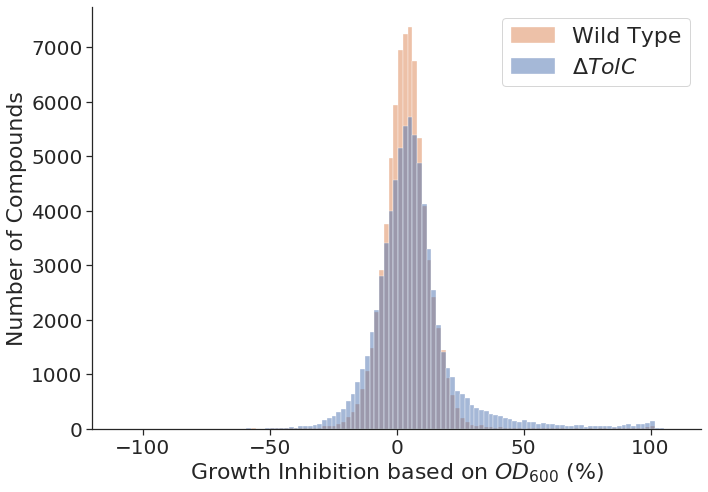

In [36]:
# e_coli_wild_efflux[['INHIB_AVE_wild', 'INHIB_AVE_efflux']].plot.hist(bins=200, alpha=0.5, figsize=[10,7])


sns.set(rc={"figure.figsize":(10, 7)})

sns.set_style("ticks")

sns.histplot(e_coli_wild_efflux[['INHIB_AVE_efflux', 'INHIB_AVE_wild']], alpha=0.5, bins=150)
sns.despine()

plt.legend(labels = ['Wild Type', '$\Delta TolC$'],  fontsize=22)

plt.xlim([-120, 120])

plt.xlabel('Growth Inhibition based on $OD_{600}$ (%)', fontsize=22);

plt.ylabel('Number of Compounds',  fontsize=22);

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)


plt.tight_layout()
# plt.savefig('figures/hist_wild_tolc.png', dpi=600)


In [4]:
e_coli_wild_efflux.INHIB_AVE_efflux.mean(), e_coli_wild_efflux.INHIB_AVE_wild.mean()

(6.611431868216318, 4.068315397968456)

In [5]:
e_coli_wild_efflux.INHIB_AVE_efflux.std(), e_coli_wild_efflux.INHIB_AVE_wild.std()

(17.071170693888337, 9.732757492784494)

In [7]:
e_coli_wild_efflux.INHIB_AVE_efflux.std()*4 + 6.6, e_coli_wild_efflux.INHIB_AVE_wild.std()*4+4.07

(74.88468277555334, 43.001029971137974)

In [64]:
stats.ttest_rel(e_coli_wild_efflux['INHIB_AVE_wild'], e_coli_wild_efflux['INHIB_AVE_efflux'])

Ttest_relResult(statistic=-44.09489438970853, pvalue=0.0)

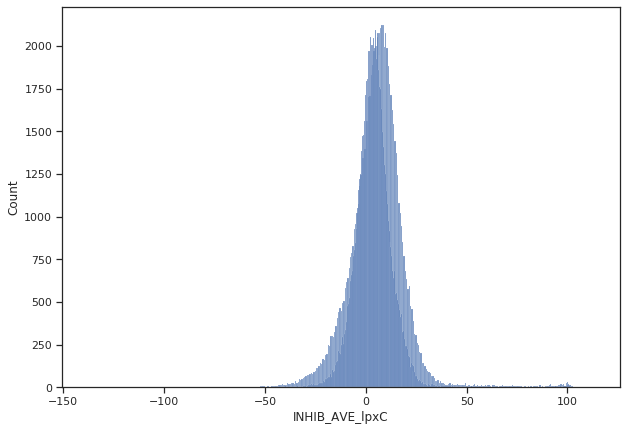

In [26]:
sns.histplot(data = e_coli_wild_perm, x='INHIB_AVE_lpxC')
sns.histplot(data = e_coli_wild_perm, x='INHIB_AVE_wild')

In [43]:
len(e_coli_wild_perm)

80620

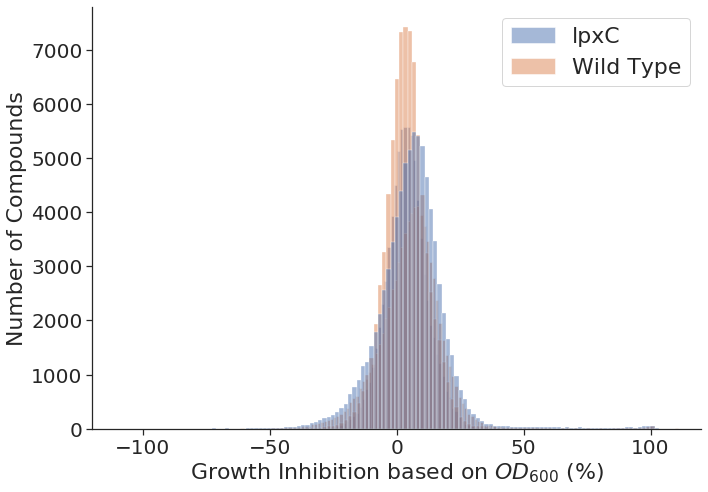

In [42]:
e_coli_wild_perm.plot.hist(bins=200, alpha=0.5, figsize=[10,7])

# e_coli_wild_efflux[['INHIB_AVE_wild', 'INHIB_AVE_efflux']].plot.hist(bins=200, alpha=0.5, figsize=[10,7])

sns.set(rc={"figure.figsize":(10, 7)})

sns.set_style("ticks")

sns.histplot(e_coli_wild_perm[['INHIB_AVE_lpxC', 'INHIB_AVE_wild']], alpha=0.5, bins=150)

sns.despine()

plt.legend(labels=['lpxC', 'Wild Type']  ,fontsize=22)

plt.xlim([-120, 120])

plt.xlabel('Growth Inhibition based on $OD_{600}$ (%)', fontsize=22);

plt.ylabel('Number of Compounds',  fontsize=22);

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)


plt.tight_layout()
plt.savefig('figures/hist_wild_lpxc.png', dpi=600)


In [9]:
stats.ttest_rel(e_coli_wild_perm['INHIB_AVE_wild'], e_coli_wild_perm['INHIB_AVE_lpxC'])

Ttest_relResult(statistic=-40.55675268375553, pvalue=0.0)

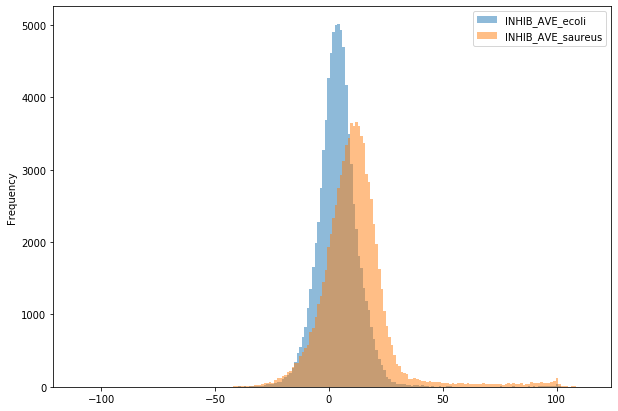

In [23]:
e_coli_s_aureus.plot.hist(bins=200, alpha=0.5, figsize=[10,7])

In [11]:
stats.ttest_rel(e_coli_s_aureus['INHIB_AVE_ecoli'], e_coli_s_aureus['INHIB_AVE_saureus'])

Ttest_relResult(statistic=-137.98270899888263, pvalue=0.0)

The goal is to assign a single value to the compound, two ways to go about that:

we will stick with absolute difference:  find lpxs - wild

### Save the curated datasets:


In [67]:
# e_coli_wild_efflux['SMILES'] = e_coli_wild_efflux['SMILES'].apply(Chem.CanonSmiles)

In [68]:
# e_coli_wild_perm.to_pickle('data_curated/e_coli_wild_perm.pkl')
# e_coli_wild_efflux.to_pickle('data_curated/e_coli_wild_efflux.pkl')
# e_coli_wild.to_pickle('data_curated/e_coli_wild.pkl')
# e_coli_s_aureus.to_pickle('data_curated/e_coli_s_aureus.pkl')

### Dev

In [112]:
# e_coli_wild_perm_only_pos = e_coli_wild_perm[(e_coli_wild_perm['INHIB_AVE_lpxC']>0) & ( e_coli_wild_perm['INHIB_AVE_wild']>0)]
# len(e_coli_wild_perm_only_pos)

44897

/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


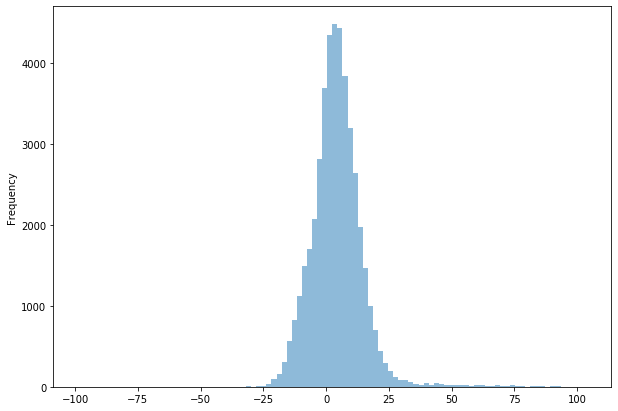

In [113]:
# e_coli_wild_perm_only_pos['perm_diff'] =  e_coli_wild_perm_only_pos['INHIB_AVE_lpxC'] - e_coli_wild_perm_only_pos['INHIB_AVE_wild']
# e_coli_wild_perm_only_pos['perm_diff'].plot.hist(bins=100, alpha=0.5, figsize=[10,7])

Another way to do that is to look at direction and take the right value like so: lpxc > wild



In [109]:
# e_coli_wild_perm_direction = e_coli_wild_perm[(e_coli_wild_perm['INHIB_AVE_lpxC']> e_coli_wild_perm['INHIB_AVE_wild'])]

In [123]:
# e_coli_wild_perm_direction['abs_diff']  = e_coli_wild_perm_direction.INHIB_AVE_lpxC - e_coli_wild_perm_direction.INHIB_AVE_wild

/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


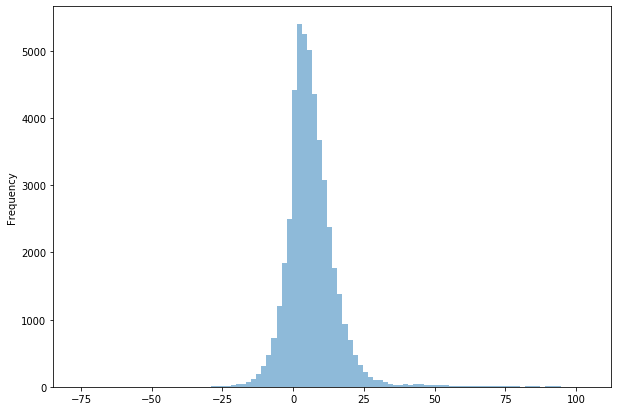

In [119]:
# e_coli_wild_perm_direction['abs_diff'].plot.hist(bins=100, alpha=0.5, figsize=[10,7])

In [125]:
# e_coli_wild_perm_direction[e_coli_wild_perm_direction['abs_diff']>0].head(20)

,SMILES,INHIB_AVE_wild,INHIB_AVE_lpxC,abs_diff
2,B(C1)(CC(C2)CC3CC12)C3.n(cc4Br)cc(c4)Br,12.08,12.83,0.75
3,B(C1)(CC(C2)CC3CC12)C3.n(cccc4Cc5ccccc5)c4,2.94,3.51,0.57
6,B(CC1CC2CC3C1)(C3)C2.N#Cc(cc4)ccn4,7.55,7.56,0.01
9,B(c1ccccc1)(OC(C)CC2P(c3ccccc3)(c4ccccc4)=O)O2,8.95,18.56,9.61
11,B1(c2ccccc2)OC(C)CC(P(c3ccccc3)c4ccccc4)O1,10.17,28.85,18.68
14,BrC(/C(OC1=C2C(C=CC=C3)=C3C=C1)=NBr)(C2C4=C(C=...,-25.63,-10.82,14.81
15,BrC(/C(OC1=C2C(C=CC=C3)=C3C=C1)=NBr)(C2C4=CC(O...,-16.78,5.16,21.94
16,BrC(/C(OC1=C2C(C=CC=C3)=C3C=C1)=NBr)(C2C4=CC([...,-20.79,0.14,20.93
18,BrC(/C(OC1=C2C(C=CC=C3)=C3C=C1)=NBr)(C2C4=CC=C...,-19.75,0.20,19.95
19,BrC(/C(OC1=C2C(C=CC=C3)=C3C=C1)=NBr)(C2C4=CC=C...,-19.01,-16.49,2.52


<!-- ### 5. Find difference in pre and post interested dataset -->


In [12]:
# e_coli_wild_perm['abs_diff']  = e_coli_wild_perm.INHIB_AVE_lpxC - e_coli_wild_perm.INHIB_AVE_wild

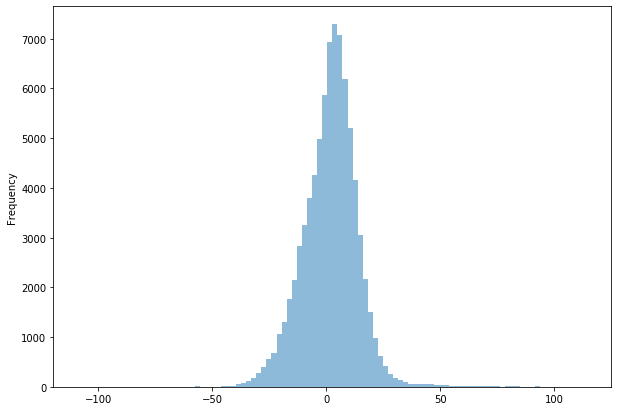

In [13]:
# e_coli_wild_perm['abs_diff'].plot.hist(bins=100, alpha=0.5, figsize=[10,7])

In [12]:
# def calc_feats(df):

#     table=pd.DataFrame()
# #     df=df.dropna() 
    
#     for i,mol in enumerate(df):
# #         Chem.SanitizeMol(mol)
# #         table.loc[i,'SMILES']=Chem.MolToSmiles(mol)
# #         table.loc[i,'Mol']=mol
#         table.loc[i,'MolWt']=Descriptors.MolWt(mol)
#         table.loc[i,'LogP']=Descriptors.MolLogP(mol)
#         table.loc[i,'NumHAcceptors']=Descriptors.NumHAcceptors(mol)
#         table.loc[i,'NumHDonors']=Descriptors.NumHDonors(mol)
#         table.loc[i,'NumHeteroatoms']=Descriptors.NumHeteroatoms(mol)
#         table.loc[i,'NumRotatableBonds']=Descriptors.NumRotatableBonds(mol)
#         table.loc[i,'NumHeavyAtoms']=Descriptors.HeavyAtomCount (mol)
#         table.loc[i,'NumAliphaticCarbocycles']=Descriptors.NumAliphaticCarbocycles(mol)
#         table.loc[i,'NumAliphaticHeterocycles']=Descriptors.NumAliphaticHeterocycles(mol)
#         table.loc[i,'NumAliphaticRings']=Descriptors.NumAliphaticRings(mol)
#         table.loc[i,'NumAromaticCarbocycles']=Descriptors.NumAromaticCarbocycles(mol)
#         table.loc[i,'NumAromaticHeterocycles']=Descriptors.NumAromaticHeterocycles(mol)
#         table.loc[i,'NumAromaticRings']=Descriptors.NumAromaticRings(mol)
#         table.loc[i,'RingCount']=Descriptors.RingCount(mol)
#         table.loc[i,'FractionCSP3']=Descriptors.FractionCSP3(mol)
#         table.loc[i,'TPSA']=Descriptors.TPSA(mol)
    
#     return table



In [20]:
e_coli_wild_efflux_features = calc_feats(e_coli_wild_efflux['Mol'])


In [22]:
e_coli_wild_efflux_features.to_pickle('data_curated/e_coli_wild_efflux_features.pkl')

In [29]:
e_coli_wild_efflux_features['sub_class'] = e_coli_wild_efflux['sub_class']

In [31]:
#pca

table = e_coli_wild_efflux_features

descriptors = table[['MolWt', 'LogP','NumHeteroatoms','RingCount','FractionCSP3', 'TPSA']].values #The non-redundant molecular descriptors chosen for PCA

# descriptors=table.iloc[:,2:]

descriptors_std = StandardScaler().fit_transform(descriptors) #Important to avoid scaling problems between our different descriptors
pca = PCA()
descriptors_2d = pca.fit_transform(descriptors_std)
descriptors_pca= pd.DataFrame(descriptors_2d) # Saving PCA values to a new table
descriptors_pca.index = table.index
descriptors_pca.columns = ['PC{}'.format(i+1) for i in descriptors_pca.columns]
descriptors_pca.head(5) #Displays the PCA table

scale1 = 1.0/(max(descriptors_pca['PC1']) - min(descriptors_pca['PC1'])) 
scale2 = 1.0/(max(descriptors_pca['PC2']) - min(descriptors_pca['PC2']))

# And we add the new values to our PCA table
descriptors_pca['PC1_normalized']=[i*scale1 for i in descriptors_pca['PC1']]
descriptors_pca['PC2_normalized']=[i*scale2 for i in descriptors_pca['PC2']]


descriptors_pca['sub_class'] = e_coli_wild_efflux_features['sub_class']



# plt.rcParams['axes.linewidth'] = 1.5


cmap = sns.diverging_palette(133, 10, as_cmap=True)

fig, ax = plt.subplots(figsize=(13,8))



sns.scatterplot(x='PC1',y='PC2',data=descriptors_pca, alpha=0.7, hue='sub_class',style='sub_class', s=30)#, palette=["C0", "C1", "C2", "k"])


pca_lab= ('PC1 '+str([np.round(pca.explained_variance_ratio_[0]*100, 1)]), 'PC2 '+str([np.round(pca.explained_variance_ratio_[1]*100, 1)]))


plt.xlabel(pca_lab[0],fontsize=16,fontweight='bold')
plt.ylabel(pca_lab[1],fontsize=16,fontweight='bold')

plt.tick_params ('both',width=2,labelsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()

#ax.legend(handles=handles[1:], labels=labels[1:])

#plt.legend(loc='lower right',frameon=False,prop={'size': 22},ncol=1)

plt.tight_layout()
plt.show()

print('same but in contours, for ease of read')

cmap = sns.diverging_palette(133, 10, as_cmap=True)

fig, ax = plt.subplots(figsize=(13,8))

sns.kdeplot(x='PC1',y='PC2',data=descriptors_pca, hue='sub_class' , levels=5,)


pca_lab= ('PC1 '+str([np.round(pca.explained_variance_ratio_[0]*100, 1)]), 'PC2 '+str([np.round(pca.explained_variance_ratio_[1]*100, 1)]))


plt.xlabel(pca_lab[0],fontsize=16,fontweight='bold')
plt.ylabel(pca_lab[1],fontsize=16,fontweight='bold')

plt.tick_params ('both',width=2,labelsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()

#ax.legend(handles=handles[1:], labels=labels[1:])

#plt.legend(loc='lower right',frameon=False,prop={'size': 22},ncol=1)

plt.tight_layout()
plt.show()

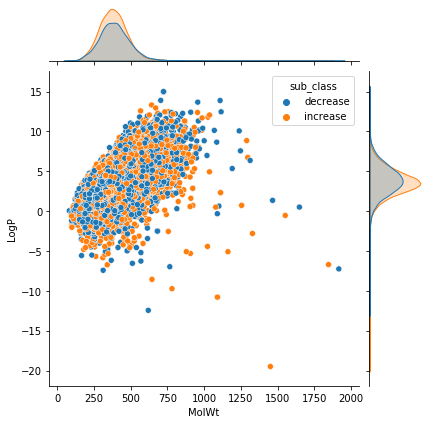

In [42]:
sns.jointplot(data = e_coli_wild_efflux_features,  x = 'MolWt',  y = 'LogP', hue='sub_class',)

In [45]:
e_coli_wild_efflux[['SMILES', 'abs_diff']].to_csv('co_add_wild_efflux.csv', index=False)

In [83]:
#### import the mmpa:



In [48]:
efflux_mmpa_index_len = master_functions.clean_mmpa_pairs_len(efflux_mmpa_index) # filter pairs by len LHS & RHS vs CORE

Initial number of transofrms: 1406980 
Number fo transforms disqualified based on length discrepancy: 526528 
Remaining number of transforms: 880452


In [ ]:
efflux_mmpa_index_len_stat = master_functions.stat_it_2(efflux_mmpa_index_len)

In [50]:
efflux_mmpa_index_len_stat.to_pickle("data_curated/efflux_mmpa_index_len_stat.pkl")

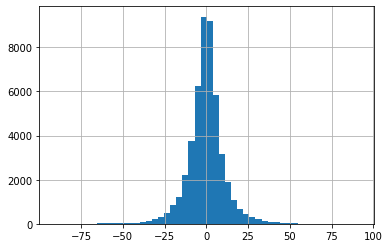

In [17]:
efflux_mmpa_index_len_stat.measurement_delta.hist(bins=50)

In [11]:
efflux_mmpa_neg_pos = master_functions.zero_in(efflux_mmpa_index_len_stat, pos_only=False, cutoff=0.05) #  is this filtering for positive?

Number of unique transforms where p-val < 0.05 is 5197
Split between 2566 positive transforms and 2631 negative transforms


In [14]:
efflux_mmpa_neg_pos = master_functions.split_transition(efflux_mmpa_neg_pos, 'smirks')

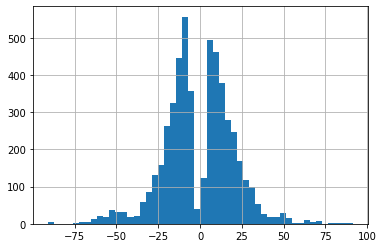

In [18]:
efflux_mmpa_neg_pos.measurement_delta.hist(bins=50)

In [42]:
efflux_mmpa_pos = efflux_mmpa_neg_pos[efflux_mmpa_neg_pos['measurement_delta']>0]

In [47]:
efflux_mmpa_pos[efflux_mmpa_pos['RHS']=='[*:1][H]']

,smirks,dof,t-stat,p-val (t-test),measurement_delta,std,sem,LHS,RHS
157,[*:1]c1nc2ccccc2o1>>[*:1][H],6,3.049545,0.022525,35.437143,30.744866,11.620467,[*:1]c1nc2ccccc2o1,[*:1][H]
476,[*:1]OCc1ccc(Cl)cc1>>[*:1][H],9,3.132617,0.012071,24.295000,24.525031,7.755496,[*:1]OCc1ccc(Cl)cc1,[*:1][H]
542,[*:1]NC(=O)c1cccc(C)c1>>[*:1][H],2,18.650861,0.002862,22.823333,2.119536,1.223715,[*:1]NC(=O)c1cccc(C)c1,[*:1][H]
559,[*:1]NC(=O)c1ccc(Cl)cc1>>[*:1][H],2,5.621207,0.030220,22.516667,6.938014,4.005664,[*:1]NC(=O)c1ccc(Cl)cc1,[*:1][H]
751,[*:1]C(=O)Nc1nnc(C)s1>>[*:1][H],2,5.034021,0.037269,19.633333,6.755223,3.900130,[*:1]C(=O)Nc1nnc(C)s1,[*:1][H]
1091,[*:1]C(=O)Nc1ccc(I)cc1>>[*:1][H],2,20.418814,0.002390,15.080000,1.279179,0.738535,[*:1]C(=O)Nc1ccc(I)cc1,[*:1][H]
1191,[*:1]CCCCCCCC>>[*:1][H],4,8.840509,0.000904,13.916000,3.519834,1.574118,[*:1]CCCCCCCC,[*:1][H]
1315,[*:1]OC(C)C>>[*:1][H],16,2.987736,0.008699,12.592941,17.378383,4.214877,[*:1]OC(C)C,[*:1][H]
1327,[*:1]NC(=O)c1ccccc1>>[*:1][H],13,3.304501,0.005698,12.444286,14.090553,3.765859,[*:1]NC(=O)c1ccccc1,[*:1][H]
1357,[*:1]NC(=O)c1ccc(C)cc1>>[*:1][H],7,2.981994,0.020457,12.155000,11.529043,4.076132,[*:1]NC(=O)c1ccc(C)cc1,[*:1][H]


In [48]:
features_all_pos, l_feats_pos, r_feats_pos = master_functions.calculate_fractions_mk4(efflux_mmpa_pos)

  1%|          | 21/2566 [00:00<00:12, 201.22it/s]

Generating molecular objects from pre-defined substructures
Calcualting LHS+RHS matches


100%|██████████| 2566/2566 [00:12<00:00, 212.06it/s]


In [49]:
to_drop = ['arene', 'heteroarene', 'alkyne', 'benzene ring', 'amine', 'azaarene', 'alkene', 'aryl halide', 'alkyl halide', 'leaving group', 'alkenyl halide']

features_all_dropped = features_all_pos.drop(to_drop, axis = 1)

l_feats_dropped =  l_feats_pos.drop(to_drop, axis = 1)
r_feats_dropped =  r_feats_pos.drop(to_drop, axis = 1)

# fractions_to_drop=['fr_ketone_Topliss', 'fr_Al_OH_noTert', 'fr_Ar_N', 'fr_methoxy', 'fr_C_O', 'fr_phenol_noOrthoHbond' ]
# fractions above are kept as significant but not looked at on the exchange

fr_sig_descriptors = master_functions.find_sig_feats_mk2(l_feats_dropped, r_feats_dropped, 0.01)

Found significant fractions:  18


In [50]:
#fr_sig_descriptors.remove('fr_NH0')
fractions_to_drop=[]

# res_neg= master_functions.results_arr(features_all.drop(columns=['fr_NH0']), fr_sig_descriptors, r_feats, l_feats, fractions_to_drop )

res_neg_neg= master_functions.results_arr(features_all_dropped, fr_sig_descriptors, r_feats_dropped, l_feats_dropped, fractions_to_drop )

aniline has negative correlation 
phenol has positive correlation 
tertiary amine has negative correlation 
enamine has negative correlation 
iminyl has negative correlation 
N-acylcarbamate or urea (mixed imide) has negative correlation 
first_gain
[('secondary carboxamide', 'carboxamide'), 'iminyl', 'aniline']
[71.43, 57.14, 14.29]
percentage_loss 100
carboxamide has negative correlation 
lactam has positive correlation 
oxime ether has positive correlation 
second double loss
['α,β-unsaturated carbonyl', ('1,2-diol', 'carboxylic acid'), 'nitro']
[-15.79, -10.53, -5.26]
alkanol has positive correlation 
second double loss
['ether', ('aryl chloride', 'aryl bromide'), 'carbonyl']
[-17.3, -8.02, -5.91]
α,β-unsaturated carbonyl has negative correlation 
carbonyl has negative correlation 
first_gain
[('aniline', 'ether'), 'aryl bromide', 'alkanol']
[10.08, 6.59, 5.81]
1,2-diol has positive correlation 
ketone has negative correlation 
alkyl fluoride has positive correlation 
aryl bromide 

In [51]:
res_neg_neg

,Main fraction,Correlation,$\overline{\Delta P}$,sem,std,dof,Opposite fraction 1,% of opposite 1,Opposite fraction 2,% of opposite 2,Opposite fraction 3,% of opposite 3
12,"1,2-diol",Positive,41.75,4.41,20.67,22,ether,-22.73,secondary amine,-9.09,aniline,-4.55
13,ketone,Negative,-30.28,4.34,22.14,26,tertiary amine,15.38,"(carboxamide, ether, aryl chloride)",7.69,tertiary carboxamide,7.69
1,phenol,Positive,26.03,1.10,16.68,228,ether,-17.98,aryl chloride,-9.21,aryl bromide,-8.33
9,alkanol,Positive,25.56,1.08,16.56,237,ether,-17.30,"(aryl chloride, aryl bromide)",-8.02,carbonyl,-5.91
3,enamine,Negative,-23.71,2.70,13.77,26,carboxamide,26.92,secondary carboxamide,23.08,hydrazone,3.85
8,oxime ether,Positive,20.57,2.60,11.35,19,"α,β-unsaturated carbonyl",-15.79,"(1,2-diol, carboxylic acid)",-10.53,nitro,-5.26
4,iminyl,Negative,-20.28,1.63,12.38,58,lactam,12.07,sulfide,8.62,primary amine,6.90
10,"α,β-unsaturated carbonyl",Negative,-20.10,1.96,13.03,44,carboxamide,22.73,secondary carboxamide,20.45,oxime ether,6.82
17,sulfide,Positive,19.98,1.22,8.87,53,aniline,-26.42,"(secondary amine, ether)",-24.53,aryl bromide,-18.87
0,aniline,Negative,-19.08,0.68,10.51,236,ether,23.73,aryl chloride,7.20,sulfide,6.78


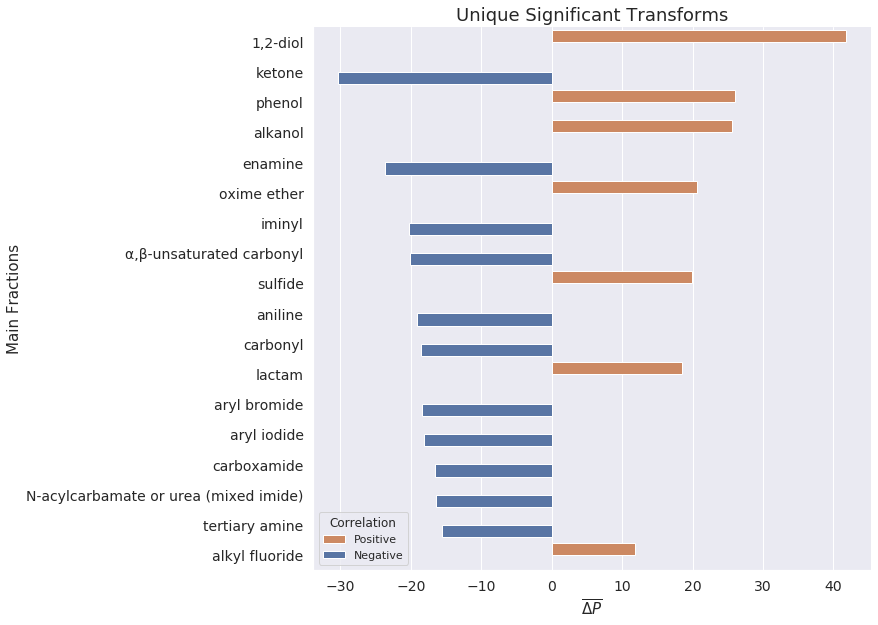

In [52]:
master_functions.plot_feats(res_neg_neg)

# Phase 2: Efflux


## Define 'active compound'


In [45]:
# 4 log_2 folds away

# below 3 std away from average

In [60]:
# z-score:
e_coli_wild_efflux['wild_stds'] = stats.zscore(e_coli_wild_efflux.INHIB_AVE_wild)
e_coli_wild_efflux['tolc_stds'] = stats.zscore(e_coli_wild_efflux.INHIB_AVE_efflux)

In [61]:
threshold = 4

def label_it(row):
    if row['wild_stds'] >=threshold:
        return 'active'
    if row['wild_stds'] <threshold:
        return 'inactive'
    
e_coli_wild_efflux['wild_class'] = e_coli_wild_efflux.apply(label_it, axis=1)

In [62]:
def label_it(row):
    if row['tolc_stds'] >=threshold:
        return 'active'
    if row['tolc_stds'] <threshold:
        return 'inactive'
    
    
e_coli_wild_efflux['tolc_class'] = e_coli_wild_efflux.apply(label_it, axis=1)

In [63]:
def label_substrate(row):
    if row['tolc_class'] == 'active' and row['wild_class'] == 'inactive':
        return 'Efflux Substrate'
    if row['tolc_class'] == 'active' and row['wild_class'] == 'active':
        return 'Efflux Evader'
    if row['tolc_class'] == 'inactive' and row['wild_class'] == 'inactive':
        return 'Inactive'
    if row['tolc_class'] == 'inactive' and row['wild_class'] == 'active':
        return 'WT-only Active'

In [64]:
e_coli_wild_efflux['Class'] = e_coli_wild_efflux.apply(label_substrate, axis=1)

In [65]:
e_coli_wild_efflux.Class.value_counts()

Inactive            72724
Efflux Substrate      760
Efflux Evader         200
WT-only Active         53
Name: Class, dtype: int64

## Scatter plot WT vs tolC

In [11]:
sns.set(rc={"figure.figsize":(10, 8)})
sns.set_style("ticks")

sns.scatterplot(data = e_coli_wild_efflux, x='INHIB_AVE_wild', y='INHIB_AVE_efflux', hue='Class', s=30)

sns.despine()

plt.legend(fontsize=20)

# plt.xlim([-120, 120])

plt.xlabel('E.coli WT Growth Inhibition (%)', fontsize=22);

plt.ylabel('E.coli $\Delta TolC$ Growth Inhibition (%)',  fontsize=22);

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.axvline(x=43.02,  color='red', linestyle='--', alpha=0.5)
plt.axhline(y=74.98,  color='red', linestyle='--', alpha=0.5)

plt.tight_layout()

# plt.savefig('figures/wild_tolc_class_scatter.png', dpi=600)

ValueError: Could not interpret value `Class` for parameter `hue`

In [5]:
e_coli_wild_efflux[e_coli_wild_efflux['wild_stds']>4].sort_values(by='wild_stds')

KeyError: 'wild_stds'

In [ ]:
e_coli_wild_efflux[e_coli_wild_efflux['wild_stds']>=4].sort_values(by='wild_stds')

,SMILES,INHIB_AVE_wild,INHIB_AVE_efflux,Mol,fps,abs_diff,sub_class,wild_stds,tolc_stds,wild_class,tolc_class,evader_class,Class
36040,CCCCCCCCCCCNC(=O)c1ccc(NC(=O)c2cccc(C)c2)cc1,43.02,85.55,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",42.53,increase,4.002149,4.624118,active,active,Evader,Evader
25810,Br.O=C(CN(C1=NCCCCC1)c1ccc(Br)cc1)c1ccc(C2CCCC...,43.06,88.91,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",45.85,increase,4.006259,4.820942,active,active,Evader,Evader
29584,CC1(c2cccc([N+](=O)[O-])c2)Nc2ccccc2C(=O)N1/N=...,43.13,76.34,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",33.21,increase,4.013451,4.084608,active,active,Evader,Evader
18822,O=C(NN=C1CSc2sc(=O)sc2SC1)c1ccccc1O,43.32,57.73,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",14.41,increase,4.032973,2.994459,active,inactive,Unclassified,Unclassified
38895,Oc1c(I)cc(I)c2cccnc12,43.38,99.77,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",56.39,increase,4.039138,5.457107,active,active,Evader,Evader
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28235,Br.CCCCCCCCCCn1ccc(=N)cc1,101.08,95.52,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-5.56,decrease,9.967611,5.208147,active,active,Evader,Evader
21558,CCN1CCN(c2cc3c(cc2F)c(=O)c(C(=O)O)cn3C2CC2)CC1,101.15,101.88,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.73,increase,9.974803,5.580708,active,active,Evader,Evader
67523,O=[N+]([O-])c1ccc(C=[N+]([O-])CCO)o1,101.33,101.32,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",-0.01,decrease,9.993298,5.547904,active,active,Evader,Evader
21276,CSC1SCC2C(=O)N(C)C(C(C)C)C(=O)OCC(NC(=O)c3cnc4...,101.44,66.39,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-35.05,decrease,10.004600,3.501750,active,inactive,Unclassified,Unclassified


In [31]:
# 4x log_2 folds

# e_coli_wild_efflux['log_2_fold_change_wild'] = np.log2(e_coli_wild_efflux.INHIB_AVE_wild / e_coli_wild_efflux.INHIB_AVE_wild.mean())
# e_coli_wild_efflux['log_2_fold_change_efflux'] = np.log2(e_coli_wild_efflux.INHIB_AVE_efflux / e_coli_wild_efflux.INHIB_AVE_efflux.mean())


/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Define substrate, evader, rest, wt-only

In [66]:
e_coli_wild_efflux['SMILES'] = e_coli_wild_efflux['SMILES'].apply(Chem.CanonSmiles)

In [68]:
efflux_substrate = e_coli_wild_efflux[e_coli_wild_efflux['Class']=='Efflux Substrate']

efflux_evader = e_coli_wild_efflux[e_coli_wild_efflux['Class']=='Efflux Evader']

wt_only = e_coli_wild_efflux[e_coli_wild_efflux['Class']=='WT-only Active']

inactive = e_coli_wild_efflux[e_coli_wild_efflux['Class']=='Inactive']

sub_and_evade = efflux_evader.append(efflux_substrate).reset_index(drop=True)

# efflux_substrate.to_pickle('data_curated/efflux_substrate.pkl')
# efflux_evader.to_pickle('data_curated/efflux_evader.pkl')
# wt_only.to_pickle('data_curated/wt_only.pkl')
# inactive.to_pickle('data_curated/inactive.pkl')
# sub_and_evade.to_pickle('data_curated/sub_and_evade.pkl')



## OM Bias

In [9]:
# Efflux evaders that are also permeators:

efflux_evaders_om_corrected = efflux_evader[efflux_evader['SMILES'].isin(om_permeating['SMILES'])]

Out of 200 efflux evades 186 are also permeators

In [10]:
# Efflux substrates that are also non-permeators:

efflux_substrates_om_corrected = efflux_substrate[efflux_substrate['SMILES'].isin(om_non_permeating['SMILES'])]

Out of 760 efflux substrates 206 are non-permeators

In [45]:
#drop 'em

efflux_substrates_om_corrected = efflux_substrate[~efflux_substrate['SMILES'].isin(om_non_permeating['SMILES'])]

In [46]:
efflux_evaders_om_corrected.to_pickle('data_curated/efflux_evaders_om_corrected.pkl')

efflux_substrates_om_corrected.to_pickle('data_curated/efflux_substrates_om_corrected.pkl')

## TSNE of evader vs substrate

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 740 samples in 0.026s...
[t-SNE] Computed neighbors for 740 samples in 0.552s...
[t-SNE] Computed conditional probabilities for sample 740 / 740
[t-SNE] Mean sigma: 1.234652
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.141048
[t-SNE] KL divergence after 1000 iterations: 0.610763


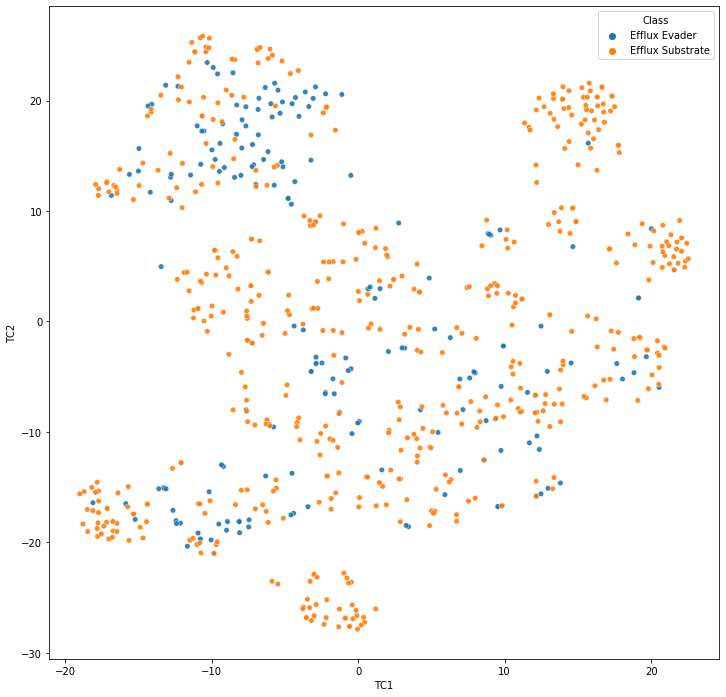

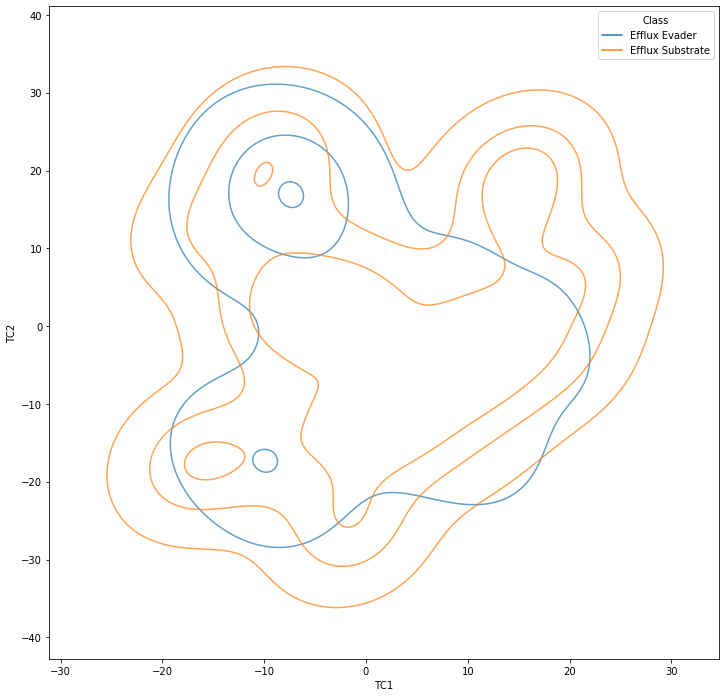

In [4]:
sub_and_evade_om_corrected_tsne = master_functions.tsne_no_plot(sub_and_evade_om_corrected['fps'], perp=50)

fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(x='TC1',y='TC2',data=sub_and_evade_om_corrected_tsne, s=30 ,alpha=0.9, hue=sub_and_evade_om_corrected['Class']) 

fig, ax = plt.subplots(figsize=(12,12))

sns.kdeplot(x='TC1',y='TC2',data=sub_and_evade_om_corrected_tsne,alpha=0.7, hue=sub_and_evade_om_corrected['Class'], levels = 4)

## TSNE of evades + substrates + rest of compounds(sample)

In [4]:
sub_evade_rest_sample = sub_and_evade_om_corrected.append(inactive.sample(3000)).reset_index(drop=True)

sub_evade_rest_sample_tsne = master_functions.tsne_no_plot(sub_evade_rest_sample['fps'], perp=30)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3740 samples in 3.440s...
[t-SNE] Computed neighbors for 3740 samples in 103.436s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3740
[t-SNE] Computed conditional probabilities for sample 2000 / 3740
[t-SNE] Computed conditional probabilities for sample 3000 / 3740
[t-SNE] Computed conditional probabilities for sample 3740 / 3740
[t-SNE] Mean sigma: 1.709593
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.862297
[t-SNE] KL divergence after 1000 iterations: 1.211201


In [5]:
sub_evade_rest_sample.Class.value_counts()

Inactive            3000
Efflux Substrate     554
Efflux Evader        186
Name: Class, dtype: int64

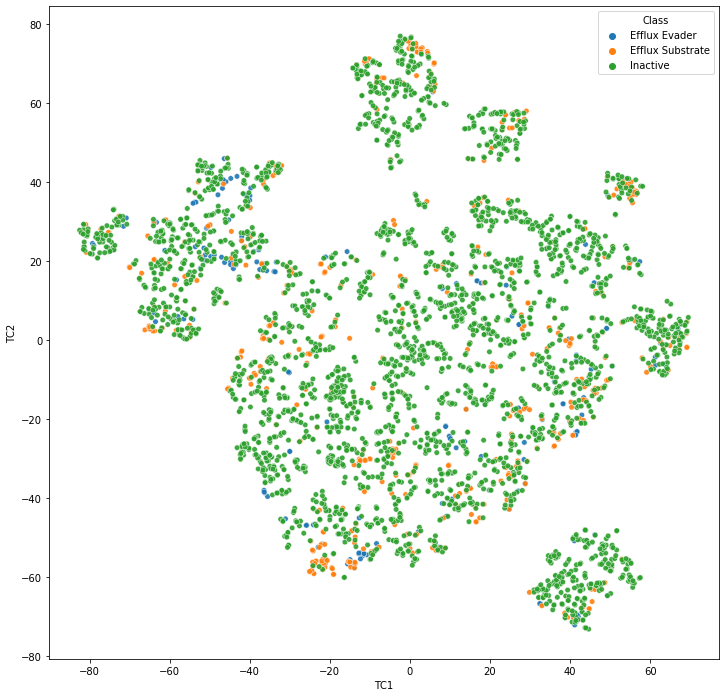

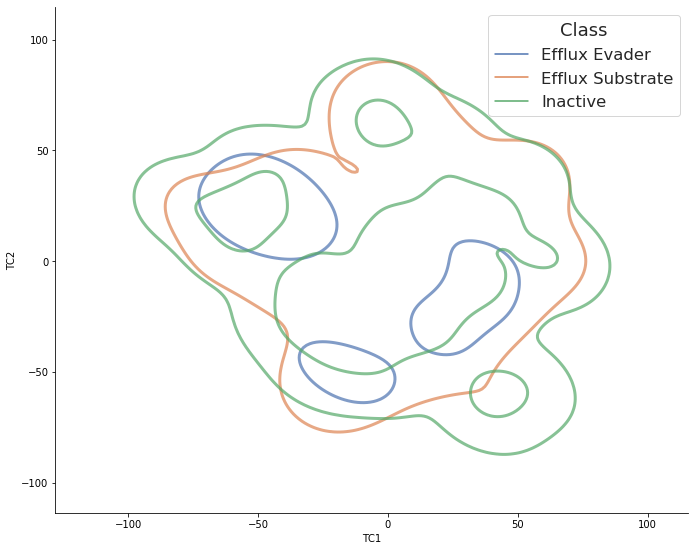

In [6]:
fig, ax = plt.subplots(figsize=(12,12))

sns.scatterplot(x='TC1',y='TC2',data=sub_evade_rest_sample_tsne, s=30 ,alpha=0.9, hue=sub_evade_rest_sample['Class']) 

fig, ax = plt.subplots(figsize=(10,8))

sns.set(font_scale=1.5)

sns.set_style("ticks")

sns.kdeplot(x='TC1',y='TC2',data=sub_evade_rest_sample_tsne,alpha=0.7, hue=sub_evade_rest_sample['Class'], levels = 3, linewidths=3 )

sns.despine()

plt.tight_layout()

plt.savefig('figures/tsne_all_contour.png', dpi=600)

# LogD v MW

In [6]:
sub_and_evade_logd['Class'] = sub_and_evade_om_corrected['Class']

In [54]:
sub_and_evade_logd

,Index,SMILES,logS,logS @ pH7.4,logD,2C9 pKi,logP,MW,HBD,HBA,TPSA,Flexibility,Rotatable Bonds,Class
0,0,OB1OCc2ccccc21,5.188,2.2370,0.07439,4.217,0.07439,133.9,1,2,29.46,0.00000,0,Efflux Evader
1,1,BrC(/C=N/Nc1nc(N2CCOCC2)nc(N2CCOCC2)n1)=C/c1cc...,2.053,0.4994,2.27200,5.529,2.78000,474.4,1,9,88.00,0.18180,6,Efflux Evader
2,2,c1cc(sc1C(=C2CN3CCC2CC3)c4ccc(s4)Cl)Cl,1.303,0.8745,3.51100,5.096,4.87400,356.3,0,1,3.24,0.08333,2,Efflux Evader
3,3,O=C(/C=C(\O)c1ccc(Br)cc1)C(F)(F)F,2.361,2.2380,1.63100,4.581,3.76600,295.1,1,2,37.30,0.18750,3,Efflux Evader
4,4,O=C(CCl)C(=O)Nc1ccccc1,4.326,2.9250,1.00300,3.932,1.00300,197.6,1,3,46.17,0.30770,4,Efflux Evader
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,735,c1ccc2c(c1)ccc3c2nc4ccccn34,1.606,1.6420,4.15400,4.902,4.15400,218.3,0,2,17.30,0.00000,0,Efflux Substrate
736,736,O=C(CSc1ccc2ccccc2n1)N/N=C/c1ccc(O)cc1O,1.119,2.5010,2.21900,4.954,2.21900,353.4,3,6,94.81,0.22220,6,Efflux Substrate
737,737,Cc1c2ccncc2c(C)c2c1[nH]c1ccccc12,1.294,0.9868,4.80000,5.346,4.80000,246.3,1,2,28.68,0.00000,0,Efflux Substrate
738,738,Cc1cc(C)c(CSc2nnc(C)s2)c(C)c1,1.607,2.4660,3.86300,4.569,3.86300,264.4,0,2,25.78,0.16670,3,Efflux Substrate


In [118]:
sub_and_evade_logd[sub_and_evade_logd['Class']=='Efflux Substrate']['logS @ pH7.4'].mean()

2.193845270758123

In [119]:
sub_and_evade_logd[sub_and_evade_logd['Class']=='Efflux Evader']['logS @ pH7.4'].mean()

2.7207848387096774

In [141]:
sub_and_evade_logd[sub_and_evade_logd['Class']=='Efflux Substrate'].TPSA.mean()

76.03005415162455

In [142]:
sub_and_evade_logd[sub_and_evade_logd['Class']=='Efflux Evader'].TPSA.mean()

96.14951612903226

In [137]:
sub_and_evade_logd[sub_and_evade_logd['Class']=='Efflux Evader']['Flexibility'].mean(), sub_and_evade_logd[sub_and_evade_logd['Class']=='Efflux Substrate']['Flexibility'].mean()

(0.1854570430107527, 0.19158178700361012)

In [138]:
sub_and_evade_logd[sub_and_evade_logd['Class']=='Efflux Evader']['Rotatable Bonds'].mean(), sub_and_evade_logd[sub_and_evade_logd['Class']=='Efflux Substrate']['Rotatable Bonds'].mean()

(4.887096774193548, 5.729241877256317)

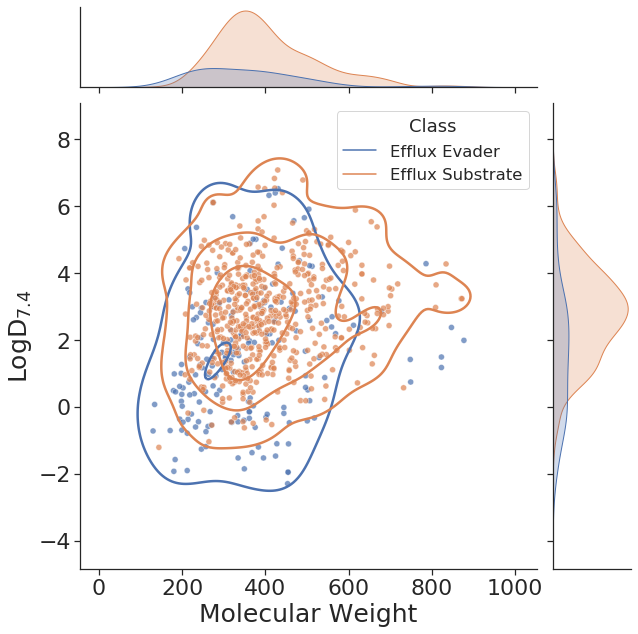

In [86]:
# sns.set(context='notebook', style='ticks', palette='deep', font='sans-serif', font_scale=1.4, color_codes=False, rc=None)


fg = sns.jointplot(data = sub_and_evade_logd, x= 'MW', y='logD', hue='Class', alpha=0.7, height = 9).plot_joint(sns.kdeplot,n_levels=4, linewidths=2.5);

## axes labels

fg.ax_joint.set_xlabel('Molecular Weight', fontsize=25)

fg.ax_joint.set_ylabel('LogD$_{7.4}$', fontsize=25)

##tick params

fg.ax_joint.tick_params(labelsize=22)

sns.despine()


plt.savefig('figures/logd_mw.png', dpi=600)

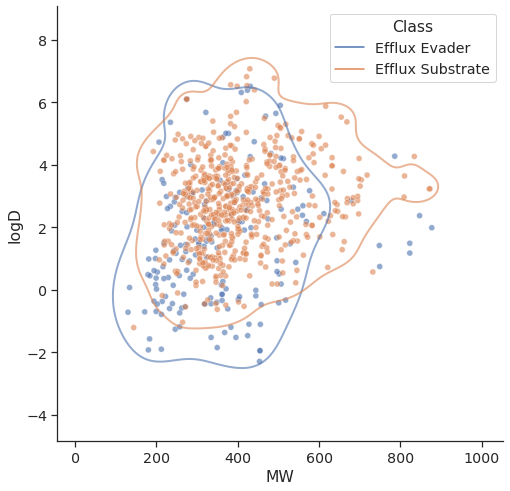

In [70]:
fig, ax = plt.subplots(figsize=(8,8))


sns.set(context='notebook', style='ticks', palette='deep', font='sans-serif', font_scale=1.3, color_codes=False, rc=None)

fig = sns.scatterplot(data = sub_and_evade_logd, x= 'MW', y='logD', hue='Class', alpha=0.6)
fig = sns.kdeplot(data = sub_and_evade_logd, x= 'MW', y='logD', hue='Class', alpha=0.6, levels=1, linewidths=2)

sns.despine()

## PCA of evader vs substrate

In [5]:
sub_and_evade_features = master_functions.calc_feats(sub_and_evade_om_corrected['Mol'])
sub_and_evade_features['Class'] = sub_and_evade_om_corrected['Class']

In [8]:
sub_and_evade_features

,MolWt,LogP,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumHeavyAtoms,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,RingCount,FractionCSP3,TPSA,Class
0,133.943,-0.09570,2.0,1.0,3.0,0.0,10.0,0.0,1.0,1.0,1.0,0.0,1.0,2.0,0.142857,29.46,Efflux Evader
1,474.363,2.37850,9.0,1.0,10.0,6.0,30.0,0.0,2.0,2.0,1.0,1.0,2.0,4.0,0.400000,88.00,Efflux Evader
2,392.804,6.06570,3.0,0.0,6.0,2.0,22.0,0.0,3.0,3.0,0.0,2.0,2.0,5.0,0.375000,3.24,Efflux Evader
3,295.054,3.47940,2.0,1.0,6.0,2.0,16.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.100000,37.30,Efflux Evader
4,197.621,1.43300,2.0,1.0,4.0,3.0,13.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.111111,46.17,Efflux Evader
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,254.720,4.06250,2.0,0.0,3.0,0.0,18.0,0.0,0.0,0.0,2.0,2.0,4.0,4.0,0.000000,17.30,Efflux Substrate
736,353.403,2.88840,6.0,3.0,7.0,5.0,25.0,0.0,0.0,0.0,2.0,1.0,3.0,3.0,0.055556,94.81,Efflux Substrate
737,246.313,4.48614,1.0,1.0,2.0,0.0,19.0,0.0,0.0,0.0,2.0,2.0,4.0,4.0,0.117647,28.68,Efflux Substrate
738,264.419,4.06408,4.0,0.0,4.0,3.0,17.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,0.384615,25.78,Efflux Substrate


In [6]:
sub_and_evade_features_200 = master_functions.calcualte_features_single(sub_and_evade_om_corrected, 'SMILES')
sub_and_evade_features_200['Class'] = sub_and_evade_om_corrected['Class']

  1%|▏         | 10/740 [00:00<00:08, 90.64it/s]

Computing features: 


100%|██████████| 740/740 [00:00<00:00, 1179.93it/s]


In [19]:
sub_and_evade_features_200 = sub_and_evade_features_200.dropna(axis=1)

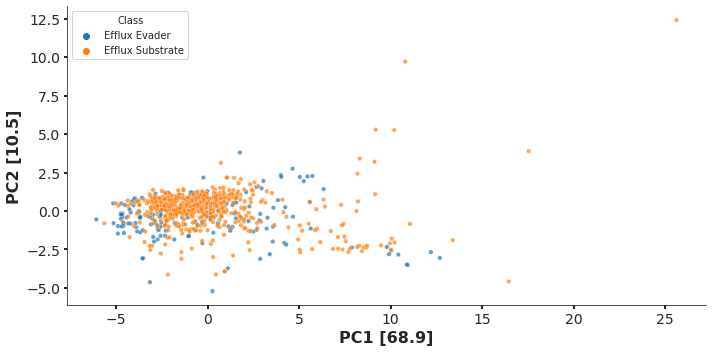

same but in contours, for ease of read


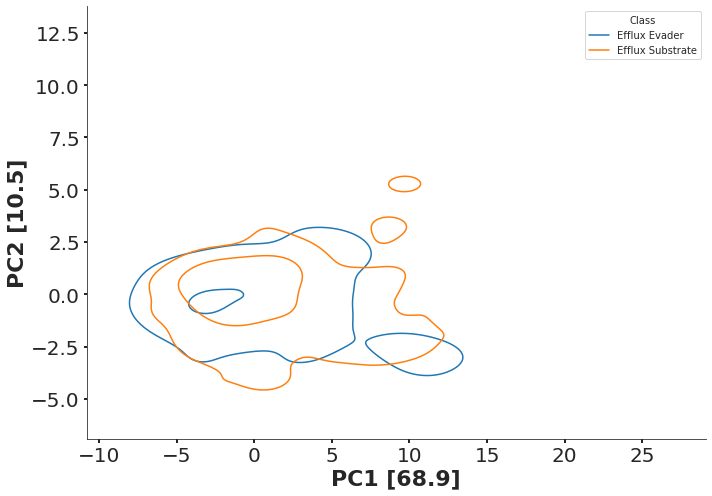

In [55]:
#pca

table = sub_and_evade_features_200

# descriptors = table[['MolWt', 'LogP','NumHeteroatoms','RingCount','FractionCSP3', 'TPSA']].values #The non-redundant molecular descriptors chosen for PCA

# descriptors=table.iloc[:,:-1]

descriptors  = table.iloc[:,:-87]

descriptors  = table.iloc[:,:-180]


descriptors_std = StandardScaler().fit_transform(descriptors) #Important to avoid scaling problems between our different descriptors
pca = PCA()
descriptors_2d = pca.fit_transform(descriptors_std)
descriptors_pca= pd.DataFrame(descriptors_2d) # Saving PCA values to a new table
descriptors_pca.index = table.index
descriptors_pca.columns = ['PC{}'.format(i+1) for i in descriptors_pca.columns]
descriptors_pca.head(5) #Displays the PCA table

scale1 = 1.0/(max(descriptors_pca['PC1']) - min(descriptors_pca['PC1'])) 
scale2 = 1.0/(max(descriptors_pca['PC2']) - min(descriptors_pca['PC2']))

# And we add the new values to our PCA table
descriptors_pca['PC1_normalized']=[i*scale1 for i in descriptors_pca['PC1']]
descriptors_pca['PC2_normalized']=[i*scale2 for i in descriptors_pca['PC2']]


descriptors_pca['Class'] = sub_and_evade_features['Class']



# plt.rcParams['axes.linewidth'] = 1.5


cmap = sns.diverging_palette(133, 10, as_cmap=True)

fig, ax = plt.subplots(figsize=(10,5))

sns.scatterplot(x='PC1',y='PC2',data=descriptors_pca, alpha=0.7, hue='Class', s=20)#, palette=["C0", "C1", "C2", "k"])


pca_lab = ('PC1 '+str([np.round(pca.explained_variance_ratio_[0]*100, 1)]), 'PC2 '+str([np.round(pca.explained_variance_ratio_[1]*100, 1)]))


plt.xlabel(pca_lab[0],fontsize=16,fontweight='bold')
plt.ylabel(pca_lab[1],fontsize=16,fontweight='bold')

plt.tick_params ('both',width=2,labelsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()

#ax.legend(handles=handles[1:], labels=labels[1:])

#plt.legend(loc='lower right',frameon=False,prop={'size': 22},ncol=1)

plt.tight_layout()

# plt.savefig('figures/pca_evade_substrate.png', dpi=600)

plt.show()

print('same but in contours, for ease of read')

cmap = sns.diverging_palette(133, 10, as_cmap=True)


############ kdeplot


fig, ax = plt.subplots(figsize=(10,7))

sns.set_style("ticks")

# sns.set(font_scale=2)

sns.kdeplot(x='PC1',y='PC2',data=descriptors_pca, hue='Class' , levels=3,)


pca_lab= ('PC1 '+str([np.round(pca.explained_variance_ratio_[0]*100, 1)]), 'PC2 '+str([np.round(pca.explained_variance_ratio_[1]*100, 1)]))


plt.xlabel(pca_lab[0],fontweight='bold',fontsize=22)
plt.ylabel(pca_lab[1],fontweight='bold', fontsize=22)

plt.tick_params ('both',width=2,labelsize=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()

#ax.legend(handles=handles[1:], labels=labels[1:])

#plt.legend(loc='lower right',frameon=False,prop={'size': 22},ncol=1)

# plt.legend()

plt.tight_layout()

# plt.savefig('figures/pca_evade_substrate_contour.png', dpi=600)

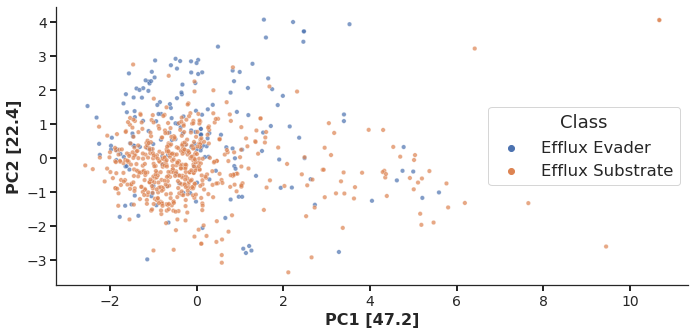

same but in contours, for ease of read


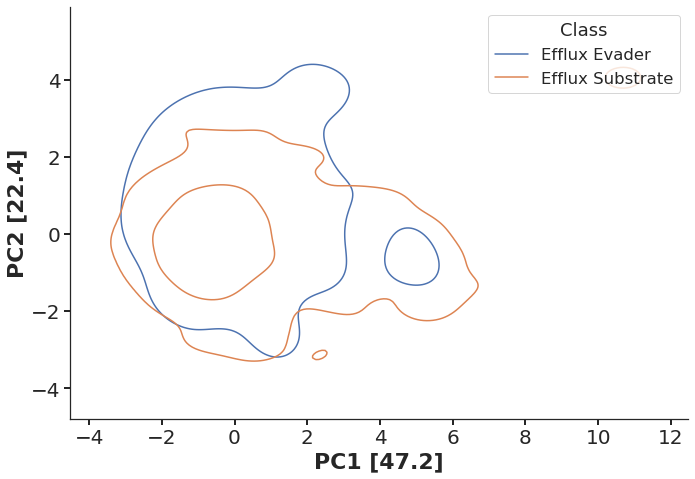

In [70]:
#pca

table = sub_and_evade_features

descriptors = table[['MolWt', 'LogP','NumHeteroatoms','RingCount','FractionCSP3', 'TPSA']].values #The non-redundant molecular descriptors chosen for PCA

# descriptors=table.iloc[:,:-1]

descriptors_std = StandardScaler().fit_transform(descriptors) #Important to avoid scaling problems between our different descriptors
pca = PCA()
descriptors_2d = pca.fit_transform(descriptors_std)
descriptors_pca= pd.DataFrame(descriptors_2d) # Saving PCA values to a new table
descriptors_pca.index = table.index
descriptors_pca.columns = ['PC{}'.format(i+1) for i in descriptors_pca.columns]
descriptors_pca.head(5) #Displays the PCA table

scale1 = 1.0/(max(descriptors_pca['PC1']) - min(descriptors_pca['PC1'])) 
scale2 = 1.0/(max(descriptors_pca['PC2']) - min(descriptors_pca['PC2']))

# And we add the new values to our PCA table
descriptors_pca['PC1_normalized']=[i*scale1 for i in descriptors_pca['PC1']]
descriptors_pca['PC2_normalized']=[i*scale2 for i in descriptors_pca['PC2']]


descriptors_pca['Class'] = sub_and_evade_features['Class']



# plt.rcParams['axes.linewidth'] = 1.5


cmap = sns.diverging_palette(133, 10, as_cmap=True)

fig, ax = plt.subplots(figsize=(10,5))

sns.scatterplot(x='PC1',y='PC2',data=descriptors_pca, alpha=0.7, hue='Class', s=20)#, palette=["C0", "C1", "C2", "k"])


pca_lab = ('PC1 '+str([np.round(pca.explained_variance_ratio_[0]*100, 1)]), 'PC2 '+str([np.round(pca.explained_variance_ratio_[1]*100, 1)]))


plt.xlabel(pca_lab[0],fontsize=16,fontweight='bold')
plt.ylabel(pca_lab[1],fontsize=16,fontweight='bold')

plt.tick_params ('both',width=2,labelsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()

#ax.legend(handles=handles[1:], labels=labels[1:])

#plt.legend(loc='lower right',frameon=False,prop={'size': 22},ncol=1)

plt.tight_layout()

# plt.savefig('figures/pca_evade_substrate.png', dpi=600)

plt.show()

print('same but in contours, for ease of read')

cmap = sns.diverging_palette(133, 10, as_cmap=True)


############ kdeplot


fig, ax = plt.subplots(figsize=(10,7))

sns.set_style("ticks")

# sns.set(font_scale=2)

sns.kdeplot(x='PC1',y='PC2',data=descriptors_pca, hue='Class' , levels=3,)


pca_lab= ('PC1 '+str([np.round(pca.explained_variance_ratio_[0]*100, 1)]), 'PC2 '+str([np.round(pca.explained_variance_ratio_[1]*100, 1)]))


plt.xlabel(pca_lab[0],fontweight='bold',fontsize=22)
plt.ylabel(pca_lab[1],fontweight='bold', fontsize=22)

plt.tick_params ('both',width=2,labelsize=20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()

#ax.legend(handles=handles[1:], labels=labels[1:])

#plt.legend(loc='lower right',frameon=False,prop={'size': 22},ncol=1)

# plt.legend()

plt.tight_layout()

# plt.savefig('figures/pca_evade_substrate_contour.png', dpi=600)

## PCA of evader _ substrates_ rest of compounds (sample)

In [76]:
rest_vs_evade_sub = sub_and_evade_om_corrected.append(inactive.sample(3000), sort=False).reset_index(drop=True)

In [77]:
rest_vs_evade_sub_features = master_functions.calc_feats(rest_vs_evade_sub['Mol'])
rest_vs_evade_sub_features['Class'] = rest_vs_evade_sub['Class']

In [78]:
rest_vs_evade_sub_features.Class.value_counts()

Inactive            3000
Efflux Substrate     554
Efflux Evader        186
Name: Class, dtype: int64

# Physicochemical feature comaprison

In [114]:
rest_vs_evade_sub_features[rest_vs_evade_sub_features['Class']=='Efflux Substrate'].LogP.mean()

3.826753321299641

In [113]:
rest_vs_evade_sub_features[rest_vs_evade_sub_features['Class']=='Efflux Evader'].LogP.mean()

2.338045215053765

In [134]:
rest_vs_evade_sub_features[rest_vs_evade_sub_features['Class']=='Efflux Substrate'].MolWt.mean()

422.1415559566788

In [135]:
rest_vs_evade_sub_features[rest_vs_evade_sub_features['Class']=='Efflux Evader'].MolWt.mean()

383.9766021505377

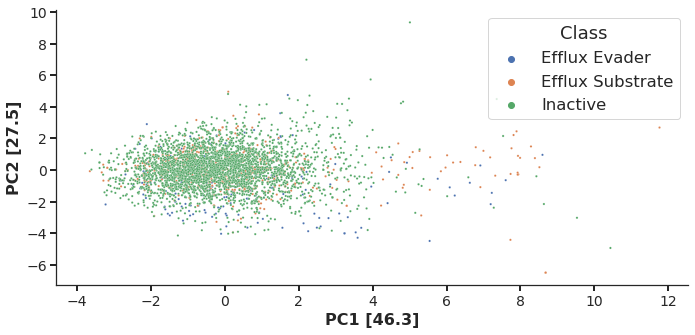

same but in contours, for ease of read


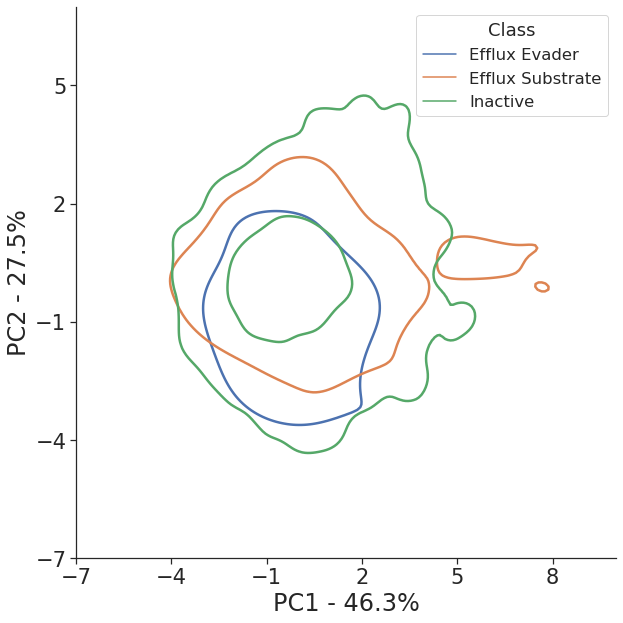

In [97]:
#pca

table = rest_vs_evade_sub_features

descriptors = table[['MolWt', 'LogP', 'TPSA', 'NumHAcceptors', 'NumHDonors', 'NumRotatableBonds']].values #The non-redundant molecular descriptors chosen for PCA

# Molecular weight, hydrogen bond donors and acceptors, topological polar surface area, rotatable bounds
# and heavy atom count are the major contributing factors to PC1, whereas LogP, 
# logD and the fraction of sp3 hybridized carbon atoms (Fsp3) are major contributors to PC2.

# descriptors=table.iloc[:,2:]

descriptors_std = StandardScaler().fit_transform(descriptors) #Important to avoid scaling problems between our different descriptors
pca = PCA()
descriptors_2d = pca.fit_transform(descriptors_std)
descriptors_pca= pd.DataFrame(descriptors_2d) # Saving PCA values to a new table
descriptors_pca.index = table.index
descriptors_pca.columns = ['PC{}'.format(i+1) for i in descriptors_pca.columns]
descriptors_pca.head(5) #Displays the PCA table

scale1 = 1.0/(max(descriptors_pca['PC1']) - min(descriptors_pca['PC1'])) 
scale2 = 1.0/(max(descriptors_pca['PC2']) - min(descriptors_pca['PC2']))

# And we add the new values to our PCA table
descriptors_pca['PC1_normalized']=[i*scale1 for i in descriptors_pca['PC1']]
descriptors_pca['PC2_normalized']=[i*scale2 for i in descriptors_pca['PC2']]


descriptors_pca['Class'] = rest_vs_evade_sub['Class']

# plt.rcParams['axes.linewidth'] = 1.5

cmap = sns.diverging_palette(133, 10, as_cmap=True)

fig, ax = plt.subplots(figsize=(10,5))

sns.set_style("ticks")

sns.scatterplot(x='PC1',y='PC2',data=descriptors_pca, alpha=1, hue='Class', s=5)#, palette=["C0", "C1", "C2", "k"])


pca_lab= ('PC1 '+str([np.round(pca.explained_variance_ratio_[0]*100, 1)]), 'PC2 '+str([np.round(pca.explained_variance_ratio_[1]*100, 1)]))


plt.xlabel(pca_lab[0],fontsize=16,fontweight='bold')
plt.ylabel(pca_lab[1],fontsize=16,fontweight='bold')

plt.tick_params ('both',width=2,labelsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()

#ax.legend(handles=handles[1:], labels=labels[1:])

#plt.legend(loc='lower right',frameon=False,prop={'size': 22},ncol=1)

plt.tight_layout()
plt.show()

print('same but in contours, for ease of read')

cmap = sns.diverging_palette(133, 10, as_cmap=True)


############# kdeplot



fig, ax = plt.subplots(figsize=(9,9))


# sns.set(font_scale=1.5)

sns.set_style("ticks")


sns.kdeplot(x='PC1',y='PC2',data=descriptors_pca, hue='Class' , levels=3, linewidths=2.5)


pca_lab= ('PC1 - '+str(np.round(pca.explained_variance_ratio_[0]*100, 1)) + '%', 'PC2 - '+str(np.round(pca.explained_variance_ratio_[1]*100, 1))  + '%')



plt.xlabel(pca_lab[0],fontsize=24)
plt.ylabel(pca_lab[1],fontsize=24)

plt.tick_params('both',labelsize=21)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()

major_ticks = np.arange(-7, 10, 3)

ax.set_xticks(major_ticks)
ax.set_yticks(major_ticks)

plt.xlim([-7,10])
plt.ylim([-7,7])

plt.tight_layout()
# plt.show()

plt.savefig('figures/pca_all_contour.png', dpi=600)

/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/seaborn/axisgrid.py:2073: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


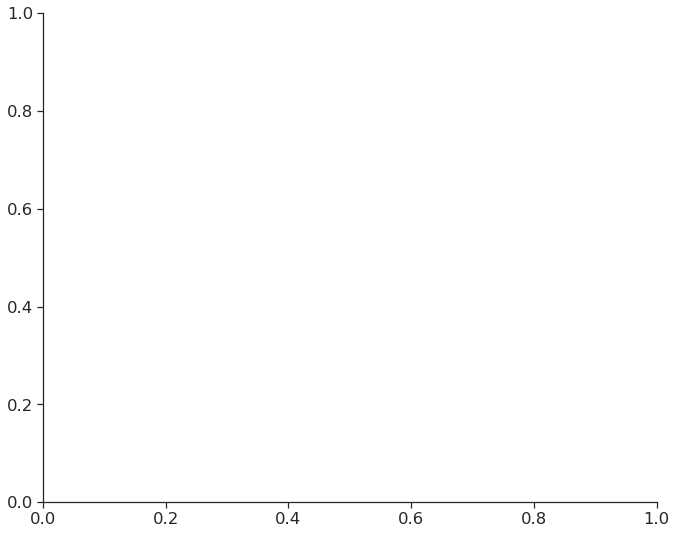

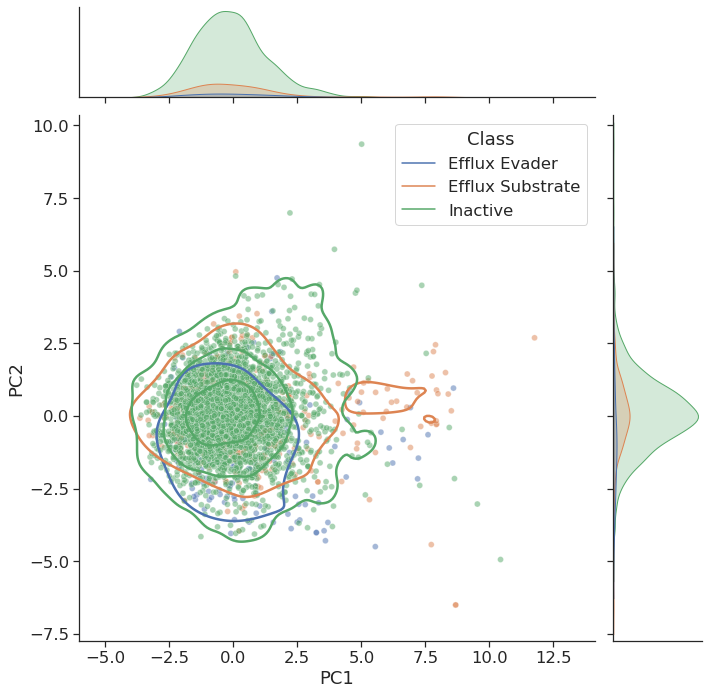

In [131]:
# sns.set(context='notebook', style='ticks', palette='deep', font='sans-serif', font_scale=1.4, color_codes=False, rc=None)


# fg = sns.jointplot(data = sub_and_evade_logd, x= 'MW', y='logD', hue='Class', alpha=0.7, height = 9).plot_joint(sns.kdeplot,n_levels=4, linewidths=2.5);


fig, ax = plt.subplots(figsize=(11,9))

fg = sns.jointplot(x='PC1',y='PC2',data=descriptors_pca, hue='Class', size=10, alpha=0.5, height = 9).plot_joint(sns.kdeplot,n_levels=4, linewidths=2.5);


# sns.scatterplot(x='PC1',y='PC2',data=descriptors_pca, hue='Class', size=10, alpha=0.5)
# sns.kdeplot(x='PC1',y='PC2',data=descriptors_pca, n_levels=4, linewidths=2.5, hue='Class');


## axes labels


pca_lab= ('PC1 - '+str(np.round(pca.explained_variance_ratio_[0]*100, 1)) + '%', 'PC2 - '+str(np.round(pca.explained_variance_ratio_[1]*100, 1))  + '%')

plt.xlabel(pca_lab[0],fontsize=24)
plt.ylabel(pca_lab[1],fontsize=24)

plt.tick_params('both',labelsize=21)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()



sns.despine()


# plt.savefig('figures/logd_mw.png', dpi=600)

## Mol vs LogP

In [57]:
list(sub_and_evade_features_200.columns)

['BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'EState_VSA1',
 'EState_VSA10',
 'EState_VSA11',
 'EState_VSA2',
 'EState_VSA3',
 'EState_VSA4',
 'EState_VSA5',
 'EState_VSA6',
 'EState_VSA7',
 'EState_VSA8',
 'EState_VSA9',
 'ExactMolWt',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'FractionCSP3',
 'HallKierAlpha',
 'HeavyAtomCount',
 'HeavyAtomMolWt',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'MaxAbsEStateIndex',
 'MaxEStateIndex',
 'MinAbsEStateIndex',
 'MinEStateIndex',
 'MolLogP',
 'MolMR',
 'MolWt',
 'NHOHCount',
 'NOCount',
 'NumAliphaticCarbocycles',
 'NumAliphaticHeterocycles',
 'NumAliphaticRings',
 'NumAromaticCarbocycles',
 'NumAromaticHeterocycles',
 'NumAromaticRings',
 'NumHAcceptors',
 'NumHDonors',
 'NumHeteroatoms',
 'NumRadicalElectrons',
 'NumRotatableBonds',
 'NumSaturatedCarbocycles',
 'NumSaturatedHeterocycles',
 'NumSaturatedRings',
 

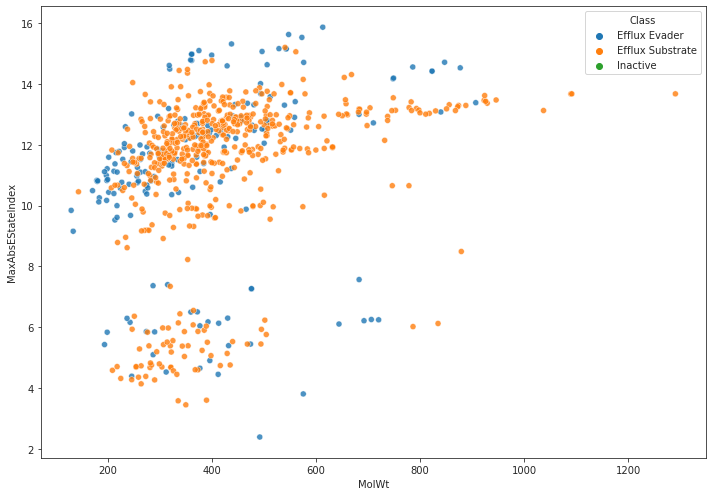

In [59]:

fig, ax = plt.subplots(figsize=(10,7))

sns.scatterplot(data = sub_and_evade_features_200, x='MolWt', y='MaxAbsEStateIndex', hue='Class', hue_order=[ 'Efflux Evader', 'Efflux Substrate', 'Inactive'], alpha=0.8 )
plt.tight_layout()

# plt.xlim([0, 1200])
# plt.ylim([-5, 12])

# plt.savefig('figures/mol_logp_kde.png', dpi=600)

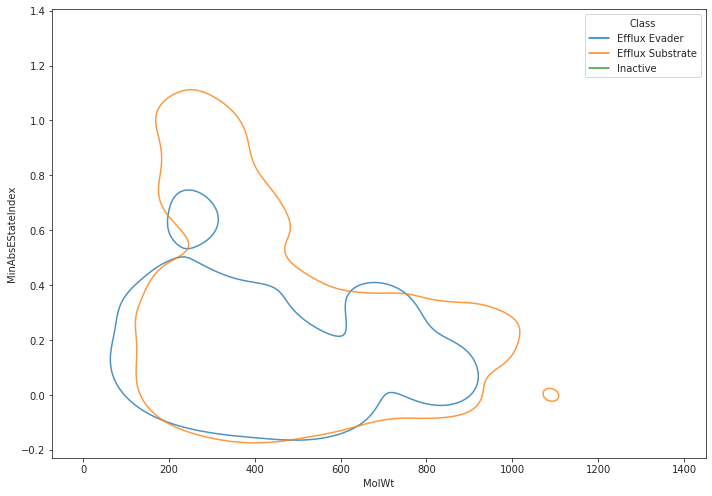

In [61]:

fig, ax = plt.subplots(figsize=(10,7))

sns.kdeplot(data = sub_and_evade_features_200, x='MolWt', y='MinAbsEStateIndex', hue='Class', hue_order=[ 'Efflux Evader', 'Efflux Substrate', 'Inactive'], alpha=0.8, levels=1 )
plt.tight_layout()

# plt.xlim([0, 1200])
# plt.ylim([-5, 12])

# plt.savefig('figures/mol_logp_kde.png', dpi=600)

## Make smiles canonical so we can compare them:


In [18]:
# make smiles canonical so we can compare them:

efflux_mmpa_index['compound_structure_B'] = efflux_mmpa_index.compound_structure_B.apply(Chem.CanonSmiles)
efflux_mmpa_index['compound_structure_A'] = efflux_mmpa_index.compound_structure_A.apply(Chem.CanonSmiles)

efflux_evader['SMILES'] = efflux_evader.SMILES.apply(Chem.CanonSmiles)
efflux_substrate['SMILES'] = efflux_substrate.SMILES.apply(Chem.CanonSmiles)

efflux_evader = efflux_evader.drop_duplicates(subset=['SMILES'])

efflux_substrate = efflux_substrate.drop_duplicates(subset=['SMILES'])

rest_of_ecoli_efflux['SMILES'] = rest_of_ecoli_efflux.SMILES.apply(Chem.CanonSmiles)

e_coli_wild_efflux['SMILES'] = e_coli_wild_efflux['SMILES'].apply(Chem.CanonSmiles)

/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


# Transforms leading to efflux evaders

In [94]:
# find efflux evaders 

evader_transforms = efflux_mmpa_index[(efflux_mmpa_index['compound_structure_B'].isin(efflux_evader.SMILES)) & (efflux_mmpa_index['compound_structure_A'].isin(rest_of_ecoli_efflux.SMILES))]

evader_transforms = master_functions.clean_mmpa_pairs_len(evader_transforms)

evader_transforms.to_pickle('data_curated/evader_transforms.pkl')

Initial number of transofrms: 2880 
Number fo transforms disqualified based on length discrepancy: 2268 
Remaining number of transforms: 612


In [23]:
len(evader_transforms.compound_structure_A.unique())

418

In [24]:
len(evader_transforms.compound_structure_B.unique())

78

In [25]:
len(evader_transforms)

612

# Transforms leading to efflux substrates

In [97]:
substrate_transforms = efflux_mmpa_index[(efflux_mmpa_index['compound_structure_B'].isin(efflux_substrate.SMILES)) & (efflux_mmpa_index['compound_structure_A'].isin(rest_of_ecoli_efflux.SMILES)) ]

substrate_transforms = master_functions.clean_mmpa_pairs_len(substrate_transforms)

substrate_transforms.to_pickle('data_curated/substrate_transforms.pkl')

Initial number of transofrms: 10619 
Number fo transforms disqualified based on length discrepancy: 2694 
Remaining number of transforms: 7925


In [98]:
len(substrate_transforms.compound_structure_A.unique())

2799

In [99]:
len(substrate_transforms.compound_structure_B.unique())

488

In [26]:
len(substrate_transforms)

7925

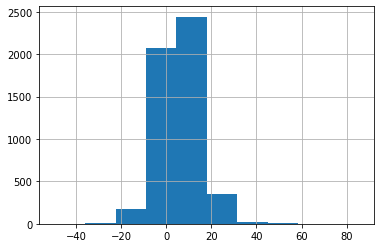

In [141]:
# e_coli_wild_efflux[e_coli_wild_efflux['SMILES'].isin(substrate_transforms.compound_structure_A)].INHIB_AVE_wild.hist()

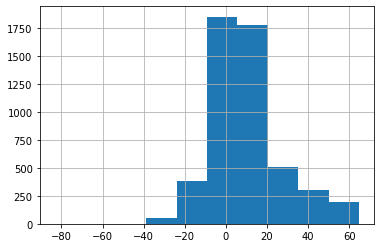

In [142]:
# e_coli_wild_efflux[e_coli_wild_efflux['SMILES'].isin(substrate_transforms.compound_structure_A)].INHIB_AVE_efflux.hist()

# Transfrom compound_A ovelap

In [4]:
evader_transforms

,compound_structure_A,compound_structure_B,idsmiles_A,idsmiles_B,smirks,common_core,measurement_A,measurement_B,measurement_delta,LHS,RHS
5578,O/C(=C\C=N\c1ccc(Br)cc1)c1ccc(Br)cc1,O=C(/C=C(\O)c1ccc(Br)cc1)C(F)(F)F,752,1153,[*:1]/C=N\c1ccc(Br)cc1>>[*:1]C(=O)C(F)(F)F,[*:1]/C=C(\O)c1ccc(Br)cc1,15.84,30.93,15.09,[*:1]/C=N\c1ccc(Br)cc1,[*:1]C(=O)C(F)(F)F
5581,Cc1ccc(/N=C/C=C(\O)c2ccc(Br)cc2)cc1,O=C(/C=C(\O)c1ccc(Br)cc1)C(F)(F)F,753,1153,[*:1]/C=N\c1ccc(C)cc1>>[*:1]C(=O)C(F)(F)F,[*:1]/C=C(\O)c1ccc(Br)cc1,-1.73,30.93,32.66,[*:1]/C=N\c1ccc(C)cc1,[*:1]C(=O)C(F)(F)F
5583,O/C(=C\C=N\c1cccc(Cl)c1)c1ccc(Br)cc1,O=C(/C=C(\O)c1ccc(Br)cc1)C(F)(F)F,755,1153,[*:1]/C=N\c1cccc(Cl)c1>>[*:1]C(=O)C(F)(F)F,[*:1]/C=C(\O)c1ccc(Br)cc1,-21.10,30.93,52.03,[*:1]/C=N\c1cccc(Cl)c1,[*:1]C(=O)C(F)(F)F
13581,COc1ccc(/C=C2\C(=O)NC(=O)N(c3ccc(C)cc3)C2=O)cc1,Cc1ccc(N2C(=O)NC(=O)/C(=C\c3ccc([N+](=O)[O-])o...,31110,31119,[*:1]c1ccc(OC)cc1>>[*:1]c1ccc([N+](=O)[O-])o1,[*:1]/C=C1\C(=O)NC(=O)N(c2ccc(C)cc2)C1=O,-2.80,-6.37,-3.57,[*:1]c1ccc(OC)cc1,[*:1]c1ccc([N+](=O)[O-])o1
13602,COc1cc(/C=C2\C(=O)NC(=O)N(c3ccc(C)cc3)C2=O)cc(...,Cc1ccc(N2C(=O)NC(=O)/C(=C\c3ccc([N+](=O)[O-])o...,31112,31119,[*:1]c1cc(I)c(O)c(OC)c1>>[*:1]c1ccc([N+](=O)[O...,[*:1]/C=C1\C(=O)NC(=O)N(c2ccc(C)cc2)C1=O,8.95,-6.37,-15.32,[*:1]c1cc(I)c(O)c(OC)c1,[*:1]c1ccc([N+](=O)[O-])o1
...,...,...,...,...,...,...,...,...,...,...,...
1404516,CCCCn1ccc(=N)cc1.I,Br.CCCCCCCCn1ccc(=N)cc1,28145,28235,[*:1]CCCC>>[*:1]CCCCCCCC,[*:1]n1ccc(=N)cc1,-14.52,32.75,47.27,[*:1]CCCC,[*:1]CCCCCCCC
1404517,CCCCn1ccc(=N)cc1.I,Br.CCCCCCCCCCn1ccc(=N)cc1,28145,28236,[*:1]CCCC>>[*:1]CCCCCCCCCC,[*:1]n1ccc(=N)cc1,-14.52,-5.56,8.96,[*:1]CCCC,[*:1]CCCCCCCCCC
1404520,Br.CCCCCCn1ccc(=N)cc1,Br.CCCCCCCCn1ccc(=N)cc1,28228,28235,[*:1]CCCCCC>>[*:1]CCCCCCCC,[*:1]n1ccc(=N)cc1,13.72,32.75,19.03,[*:1]CCCCCC,[*:1]CCCCCCCC
1404521,Br.CCCCCCn1ccc(=N)cc1,Br.CCCCCCCCCCn1ccc(=N)cc1,28228,28236,[*:1]CCCCCC>>[*:1]CCCCCCCCCC,[*:1]n1ccc(=N)cc1,13.72,-5.56,-19.28,[*:1]CCCCCC,[*:1]CCCCCCCCCC


In [150]:
len(evader_transforms.merge(evader_transforms, on = ['compound_structure_A']).compound_structure_A.unique())

418

In [7]:
comp_a_evader_overlap = evader_transforms[evader_transforms.compound_structure_A.isin(substrate_transforms.compound_structure_A)]

In [8]:
len(comp_a_evader_overlap)

164

In [9]:
len(comp_a_evader_overlap.compound_structure_B.unique())

30

In [10]:
comp_a_substrate_overlap = substrate_transforms[substrate_transforms.compound_structure_A.isin(evader_transforms.compound_structure_A)]

In [11]:
len(comp_a_substrate_overlap.compound_structure_B.unique())

71

In [12]:
len(comp_a_substrate_overlap)

377

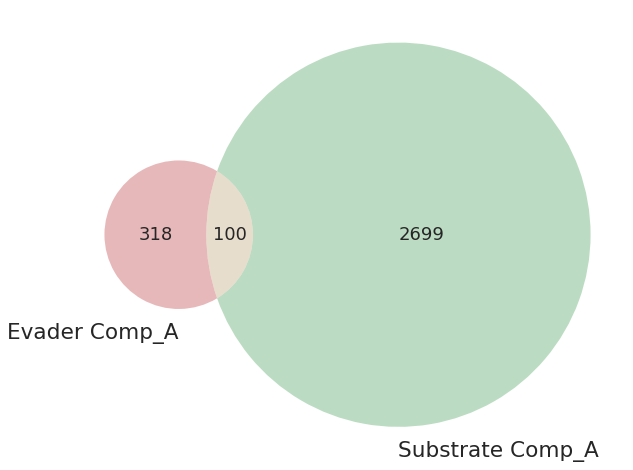

In [18]:
plt.figure(figsize=(10,10))


venn2([ set(evader_transforms.compound_structure_A.to_list()), 
        set(substrate_transforms.compound_structure_A.to_list())],
        set_labels=('Evader Comp_A', 'Substrate Comp_A')
     )

In [22]:
len(substrate_transforms.compound_structure_A.unique())

2799

## How are overlapping transforms split?

In [106]:
len(comp_a_evader_overlap[comp_a_evader_overlap['compound_structure_A'].isin(evader_transforms.compound_structure_A)])

89

In [61]:
len(comp_a_evader_substrate_overlap.compound_structure_B.unique())

96

In [68]:
len(substrate_transforms[substrate_transforms['compound_structure_B'].isin(comp_a_evader_substrate_overlap.compound_structure_B)].compound_structure_B.unique())

96

In [81]:
len(comp_a_substrate_evader_overlap[comp_a_substrate_evader_overlap['compound_structure_B'].isin(evader_transforms.compound_structure_B)].compound_structure_B.unique())

46

In [73]:
len(evader_transforms[evader_transforms['compound_structure_B'].isin(comp_a_evader_substrate_overlap.compound_structure_B)].compound_structure_B.unique())

0

# TSNE of RHS and LHS of overlap

In [106]:
comp_a_substrate_overlap['mol_b'] = comp_a_substrate_overlap.compound_structure_B.apply(Chem.MolFromSmiles)
comp_a_substrate_overlap['label'] = 'substrate_overlap_B'
comp_a_substrate_overlap = comp_a_substrate_overlap.dropna(subset=['mol_b'])

comp_a_substrate_overlap['fps']=comp_a_substrate_overlap.mol_b.apply(MACCSkeys.GenMACCSKeys)

unique_substrate =  comp_a_substrate_overlap.drop_duplicates(subset=['compound_structure_B'])



/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [107]:
comp_a_evader_overlap['mol_b'] = comp_a_evader_overlap.compound_structure_B.apply(Chem.MolFromSmiles)
comp_a_evader_overlap['label'] = 'evader_overlap_B'
comp_a_evader_overlap = comp_a_evader_overlap.dropna(subset=['mol_b'])

comp_a_evader_overlap['fps']=comp_a_evader_overlap.mol_b.apply(MACCSkeys.GenMACCSKeys)

unique_evader =  comp_a_evader_overlap.drop_duplicates(subset=['compound_structure_B'])


/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [108]:
append = unique_evader.append(unique_substrate).reset_index(drop=True)

In [109]:
append.label.value_counts()

substrate_overlap_B    71
evader_overlap_B       30
Name: label, dtype: int64

In [110]:
len(append)

101

In [115]:
append_tsne =  master_functions.tsne_no_plot(append['fps'], 5)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 101 samples in 0.001s...
[t-SNE] Computed neighbors for 101 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 101 / 101
[t-SNE] Mean sigma: 0.341923
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.464149
[t-SNE] KL divergence after 1000 iterations: 0.468673


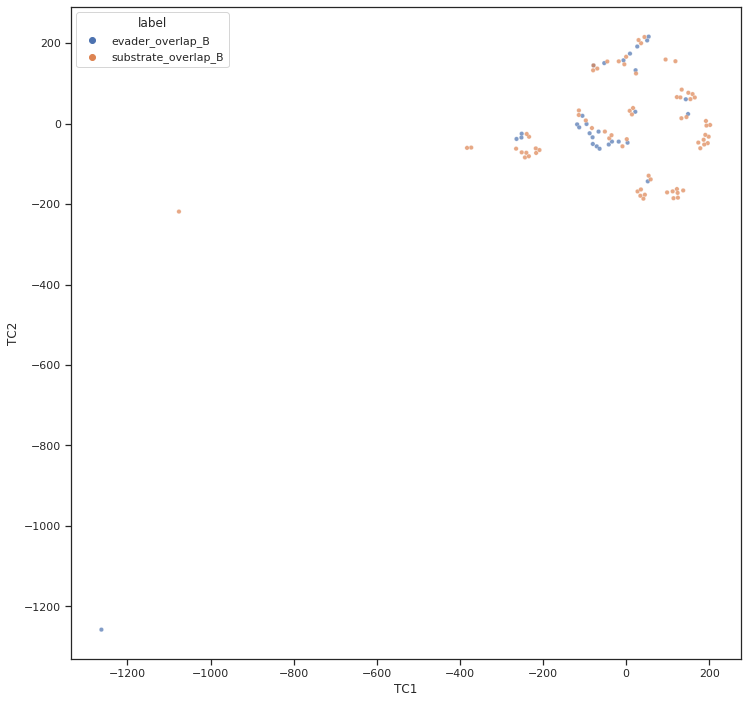

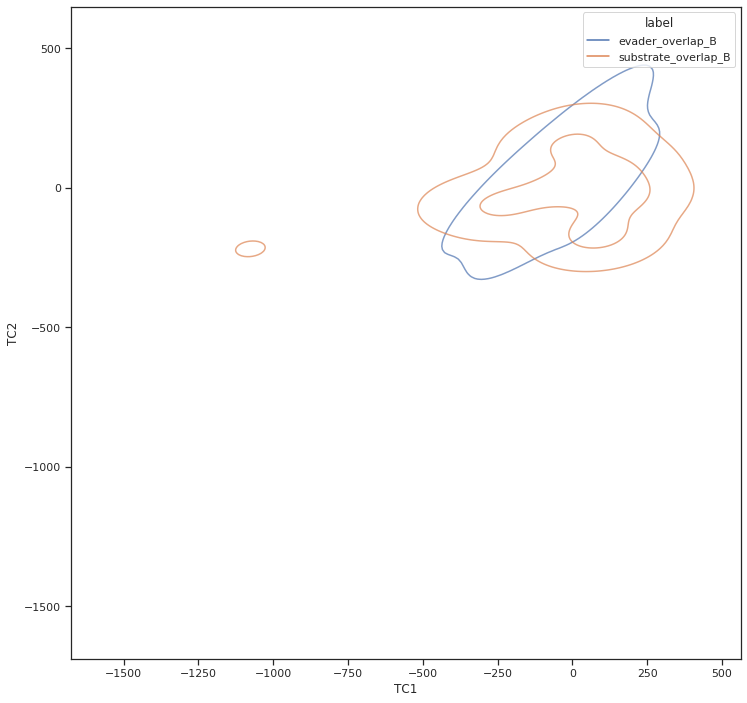

In [116]:
append_tsne =  master_functions.tsne_no_plot(append['fps'], 5)

fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(x='TC1',y='TC2',data=append_tsne, s=20 ,alpha=0.7, hue=append['label']) 

fig, ax = plt.subplots(figsize=(12,12))

sns.kdeplot(x='TC1',y='TC2',data=append_tsne,alpha=0.7, hue=append['label'], levels = 3)

# Physchem of overlap

In [79]:
unique_evader_transforms = comp_a_evader_overlap.drop_duplicates(subset=['compound_structure_A'])

unique_evader_transforms['Mol_A'] = unique_evader_transforms.compound_structure_A.apply(Chem.MolFromSmiles)
unique_evader_transforms['Mol_B'] = unique_evader_transforms.compound_structure_B.apply(Chem.MolFromSmiles)


unique_evader_transforms_comp_a = comp_a_evader_overlap.drop_duplicates(subset=['compound_structure_A'])[['compound_structure_A']]
unique_evader_transforms_comp_b = comp_a_evader_overlap.drop_duplicates(subset=['compound_structure_A'])[['compound_structure_B']]

/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [80]:
unique_substrate_transforms = comp_a_substrate_overlap.drop_duplicates(subset=['compound_structure_A'])

unique_substrate_transforms['Mol_A'] = unique_substrate_transforms.compound_structure_A.apply(Chem.MolFromSmiles)
unique_substrate_transforms['Mol_B'] = unique_substrate_transforms.compound_structure_B.apply(Chem.MolFromSmiles)

# unique_substrate_transforms_comp_a = comp_a_substrate_overlap.drop_duplicates(subset=['compound_structure_A'])[['compound_structure_A']]

# unique_substrate_transforms_comp_b = comp_a_substrate_overlap.drop_duplicates(subset=['compound_structure_A'])[['compound_structure_B']]

/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/homes/dgurvic/software/miniconda3/envs/jupt_test/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [82]:
unique_substrate_transforms_comp_b_feats = master_functions.calc_feats(unique_substrate_transforms.Mol_B)

In [83]:
unique_substrate_transforms_comp_b_feats

,MolWt,LogP,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumHeavyAtoms,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,RingCount,FractionCSP3,TPSA
0,195.174,1.64820,4.0,1.0,5.0,3.0,14.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.111111,72.60
1,195.174,1.64820,4.0,1.0,5.0,3.0,14.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.111111,72.60
2,195.174,1.64820,4.0,1.0,5.0,3.0,14.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.111111,72.60
3,195.174,1.64820,4.0,1.0,5.0,3.0,14.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.111111,72.60
4,195.174,1.64820,4.0,1.0,5.0,3.0,14.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.111111,72.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,333.100,4.34550,3.0,1.0,9.0,1.0,21.0,0.0,0.0,0.0,1.0,2.0,3.0,3.0,0.083333,54.46
646,320.218,3.55597,2.0,1.0,3.0,6.0,15.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.583333,28.78
647,320.218,3.55597,2.0,1.0,3.0,6.0,15.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.583333,28.78
648,320.218,3.55597,2.0,1.0,3.0,6.0,15.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.583333,28.78


In [19]:
e_coli_wild_efflux_feats = calc_feats(comp_a_evader_overlap)

e_coli_wild_efflux_feats = e_coli_wild_efflux_feats.dropna()



ArgumentError: Python argument types in
    rdkit.Chem.rdMolDescriptors._CalcMolWt(str)
did not match C++ signature:
    _CalcMolWt(RDKit::ROMol mol, bool onlyHeavy=False)

In [85]:
master_functions.clean_mmpa_pairs_len(evader_transforms)

Initial number of transofrms: 2385 
Number fo transforms disqualified based on length discrepancy: 1948 
Remaining number of transforms: 437


,compound_structure_A,compound_structure_B,idsmiles_A,idsmiles_B,smirks,common_core,measurement_A,measurement_B,measurement_delta,LHS,RHS
5578,O/C(=C\C=N\c1ccc(Br)cc1)c1ccc(Br)cc1,O=C(/C=C(\O)c1ccc(Br)cc1)C(F)(F)F,752,1153,[*:1]/C=N\c1ccc(Br)cc1>>[*:1]C(=O)C(F)(F)F,[*:1]/C=C(\O)c1ccc(Br)cc1,15.84,30.93,15.09,[*:1]/C=N\c1ccc(Br)cc1,[*:1]C(=O)C(F)(F)F
5581,Cc1ccc(/N=C/C=C(\O)c2ccc(Br)cc2)cc1,O=C(/C=C(\O)c1ccc(Br)cc1)C(F)(F)F,753,1153,[*:1]/C=N\c1ccc(C)cc1>>[*:1]C(=O)C(F)(F)F,[*:1]/C=C(\O)c1ccc(Br)cc1,-1.73,30.93,32.66,[*:1]/C=N\c1ccc(C)cc1,[*:1]C(=O)C(F)(F)F
5583,O/C(=C\C=N\c1cccc(Cl)c1)c1ccc(Br)cc1,O=C(/C=C(\O)c1ccc(Br)cc1)C(F)(F)F,755,1153,[*:1]/C=N\c1cccc(Cl)c1>>[*:1]C(=O)C(F)(F)F,[*:1]/C=C(\O)c1ccc(Br)cc1,-21.10,30.93,52.03,[*:1]/C=N\c1cccc(Cl)c1,[*:1]C(=O)C(F)(F)F
13581,COc1ccc(/C=C2\C(=O)NC(=O)N(c3ccc(C)cc3)C2=O)cc1,Cc1ccc(N2C(=O)NC(=O)/C(=C\c3ccc([N+](=O)[O-])o...,31110,31119,[*:1]c1ccc(OC)cc1>>[*:1]c1ccc([N+](=O)[O-])o1,[*:1]/C=C1\C(=O)NC(=O)N(c2ccc(C)cc2)C1=O,-2.80,-6.37,-3.57,[*:1]c1ccc(OC)cc1,[*:1]c1ccc([N+](=O)[O-])o1
13602,COc1cc(/C=C2\C(=O)NC(=O)N(c3ccc(C)cc3)C2=O)cc(...,Cc1ccc(N2C(=O)NC(=O)/C(=C\c3ccc([N+](=O)[O-])o...,31112,31119,[*:1]c1cc(I)c(O)c(OC)c1>>[*:1]c1ccc([N+](=O)[O...,[*:1]/C=C1\C(=O)NC(=O)N(c2ccc(C)cc2)C1=O,8.95,-6.37,-15.32,[*:1]c1cc(I)c(O)c(OC)c1,[*:1]c1ccc([N+](=O)[O-])o1
...,...,...,...,...,...,...,...,...,...,...,...
1404506,Br.CCn1ccc(=N)cc1,Br.CCCCCCCCCCn1ccc(=N)cc1,27987,28236,[*:1]CC>>[*:1]CCCCCCCCCC,[*:1]n1ccc(=N)cc1,-6.60,-5.56,1.04,[*:1]CC,[*:1]CCCCCCCCCC
1404512,CCCn1ccc(=N)cc1.I,Br.CCCCCCCCCCn1ccc(=N)cc1,28118,28236,[*:1]CCC>>[*:1]CCCCCCCCCC,[*:1]n1ccc(=N)cc1,1.42,-5.56,-6.98,[*:1]CCC,[*:1]CCCCCCCCCC
1404517,CCCCn1ccc(=N)cc1.I,Br.CCCCCCCCCCn1ccc(=N)cc1,28145,28236,[*:1]CCCC>>[*:1]CCCCCCCCCC,[*:1]n1ccc(=N)cc1,-14.52,-5.56,8.96,[*:1]CCCC,[*:1]CCCCCCCCCC
1404521,Br.CCCCCCn1ccc(=N)cc1,Br.CCCCCCCCCCn1ccc(=N)cc1,28228,28236,[*:1]CCCCCC>>[*:1]CCCCCCCCCC,[*:1]n1ccc(=N)cc1,13.72,-5.56,-19.28,[*:1]CCCCCC,[*:1]CCCCCCCCCC


In [86]:
master_functions.clean_mmpa_pairs_len(substrate_transforms)

Initial number of transofrms: 14668 
Number fo transforms disqualified based on length discrepancy: 4150 
Remaining number of transforms: 10518


,compound_structure_A,compound_structure_B,idsmiles_A,idsmiles_B,smirks,common_core,measurement_A,measurement_B,measurement_delta,LHS,RHS
329,C/C(=N\NC(=O)c1nnn(-c2nonc2N)c1-c1ccccc1)c1ccc...,Nc1nonc1-n1nnc(C(=O)N/N=C/c2ccccc2O)c1-c1ccccc1,69387,69423,[*:1]C>>[*:1][H],[*:1]/C(=N\NC(=O)c1nnn(-c2nonc2N)c1-c1ccccc1)c...,8.85,55.86,47.01,[*:1]C,[*:1][H]
2191,C/C(=N\Nc1nc(Nc2cccc(Br)c2)nc(N2CCOCC2)n1)c1cc...,C/C(=N\Nc1nc(Nc2cccc(Br)c2)nc(N2CCOCC2)n1)c1cc...,54132,54133,[*:1]c1ccc(Cl)cc1>>[*:1]c1ccc(N)cc1,[*:1]/C(C)=N/Nc1nc(Nc2cccc(Br)c2)nc(N2CCOCC2)n1,-0.44,63.09,63.53,[*:1]c1ccc(Cl)cc1,[*:1]c1ccc(N)cc1
2258,C/C(=N/Nc1nc(Nc2cccc(Br)c2)nc(N2CCOCC2)n1)c1cc...,C/C(=N/Nc1nc(Nc2cccc(Br)c2)nc(N2CCOCC2)n1)c1cc...,54138,54140,[*:1]c1ccc(Br)cc1>>[*:1]c1ccccc1,[*:1]/C(C)=N\Nc1nc(Nc2cccc(Br)c2)nc(N2CCOCC2)n1,14.87,66.49,51.62,[*:1]c1ccc(Br)cc1,[*:1]c1ccccc1
2259,C/C(=N/Nc1nc(Nc2cccc(Br)c2)nc(N2CCOCC2)n1)c1cc...,C/C(=N/Nc1nc(Nc2cccc(Br)c2)nc(N2CCOCC2)n1)c1cc...,54139,54140,[*:1]c1ccc(F)cc1>>[*:1]c1ccccc1,[*:1]/C(C)=N\Nc1nc(Nc2cccc(Br)c2)nc(N2CCOCC2)n1,47.29,66.49,19.20,[*:1]c1ccc(F)cc1,[*:1]c1ccccc1
2723,Cc1ccc2[nH]c(/C(C#N)=C/c3c(Cl)cccc3Cl)nc2c1,Cc1ccc2[nH]c(/C(C#N)=C/c3cc(Br)c(O)c(Br)c3)nc2c1,58348,58331,[*:1]c1c(Cl)cccc1Cl>>[*:1]c1cc(Br)c(O)c(Br)c1,[*:1]/C=C(\C#N)c1nc2cc(C)ccc2[nH]1,3.82,62.41,58.59,[*:1]c1c(Cl)cccc1Cl,[*:1]c1cc(Br)c(O)c(Br)c1
...,...,...,...,...,...,...,...,...,...,...,...
1405589,Cc1ccccc1NCn1nc(-c2ccc(Cl)cc2Cl)oc1=S,OCn1nc(-c2ccc(Cl)cc2Cl)oc1=S,28917,13687,[*:1]CNc1ccccc1C>>[*:1]CO,[*:1]n1nc(-c2ccc(Cl)cc2Cl)oc1=S,46.66,61.85,15.19,[*:1]CNc1ccccc1C,[*:1]CO
1406560,O=[N+]([O-])c1ccc(-n2ncc3c([N+](=O)[O-])cc([N+...,O=[N+]([O-])c1cc([N+](=O)[O-])c2cn[nH]c2c1,63724,62159,[*:1]c1ccc([N+](=O)[O-])cc1>>[*:1][H],[*:1]n1ncc2c([N+](=O)[O-])cc([N+](=O)[O-])cc21,-19.26,80.56,99.82,[*:1]c1ccc([N+](=O)[O-])cc1,[*:1][H]
1406563,Cc1ccc(-n2ncc3c([N+](=O)[O-])cc([N+](=O)[O-])c...,O=[N+]([O-])c1cc([N+](=O)[O-])c2cn[nH]c2c1,63726,62159,[*:1]c1ccc(C)cc1>>[*:1][H],[*:1]n1ncc2c([N+](=O)[O-])cc([N+](=O)[O-])cc21,-14.22,80.56,94.78,[*:1]c1ccc(C)cc1,[*:1][H]
1406565,O=C(O)c1ccccc1-n1ncc2c([N+](=O)[O-])cc([N+](=O...,O=[N+]([O-])c1cc([N+](=O)[O-])c2cn[nH]c2c1,70401,62159,[*:1]c1ccccc1C(=O)O>>[*:1][H],[*:1]n1ncc2c([N+](=O)[O-])cc([N+](=O)[O-])cc21,-8.49,80.56,89.05,[*:1]c1ccccc1C(=O)O,[*:1][H]


In [15]:
a, b, c = master_functions.calculate_fractions_mk4(comp_a_evader_overlap)


  0%|          | 8/1609 [00:00<00:20, 79.63it/s]

Generating molecular objects from pre-defined substructures
Calcualting LHS+RHS matches


100%|██████████| 1609/1609 [00:09<00:00, 173.84it/s]


In [14]:
features_all_evade, l_feats_evade, r_feats_evade = master_functions.calculate_fractions_mk4(evader_transforms)


  0%|          | 1/2385 [00:00<06:05,  6.53it/s]

Generating molecular objects from pre-defined substructures
Calcualting LHS+RHS matches


100%|██████████| 2385/2385 [00:12<00:00, 183.98it/s]


In [13]:
features_all_neg, l_feats_neg, r_feats_neg = master_functions.calculate_fractions_mk4(mmpa_zero_neg)

features_all_pos, l_feats_pos, r_feats_pos = master_functions.calculate_fractions_mk4(mmpa_zero_pos)

,compound_structure_A,compound_structure_B,idsmiles_A,idsmiles_B,smirks,common_core,measurement_A,measurement_B,measurement_delta,LHS,RHS
5578,O/C(=C\C=N\c1ccc(Br)cc1)c1ccc(Br)cc1,O=C(/C=C(\O)c1ccc(Br)cc1)C(F)(F)F,752,1153,[*:1]/C=N\c1ccc(Br)cc1>>[*:1]C(=O)C(F)(F)F,[*:1]/C=C(\O)c1ccc(Br)cc1,15.84,30.93,15.09,[*:1]/C=N\c1ccc(Br)cc1,[*:1]C(=O)C(F)(F)F
5581,Cc1ccc(/N=C/C=C(\O)c2ccc(Br)cc2)cc1,O=C(/C=C(\O)c1ccc(Br)cc1)C(F)(F)F,753,1153,[*:1]/C=N\c1ccc(C)cc1>>[*:1]C(=O)C(F)(F)F,[*:1]/C=C(\O)c1ccc(Br)cc1,-1.73,30.93,32.66,[*:1]/C=N\c1ccc(C)cc1,[*:1]C(=O)C(F)(F)F
5583,O/C(=C\C=N\c1cccc(Cl)c1)c1ccc(Br)cc1,O=C(/C=C(\O)c1ccc(Br)cc1)C(F)(F)F,755,1153,[*:1]/C=N\c1cccc(Cl)c1>>[*:1]C(=O)C(F)(F)F,[*:1]/C=C(\O)c1ccc(Br)cc1,-21.10,30.93,52.03,[*:1]/C=N\c1cccc(Cl)c1,[*:1]C(=O)C(F)(F)F
5584,COc1ccccc1/N=C/C=C(\O)c1ccc(Br)cc1,O=C(/C=C(\O)c1ccc(Br)cc1)C(F)(F)F,756,1153,[*:1]/C=N\c1ccccc1OC>>[*:1]C(=O)C(F)(F)F,[*:1]/C=C(\O)c1ccc(Br)cc1,6.04,30.93,24.89,[*:1]/C=N\c1ccccc1OC,[*:1]C(=O)C(F)(F)F
5998,CN(/C=C/[N+](=O)[O-])c1ccccc1,O=[N+]([O-])/C=C/c1ccc(Cl)cc1Cl,43517,43527,[*:1]N(C)c1ccccc1>>[*:1]c1ccc(Cl)cc1Cl,[*:1]/C=C/[N+](=O)[O-],0.93,-0.05,-0.98,[*:1]N(C)c1ccccc1,[*:1]c1ccc(Cl)cc1Cl
...,...,...,...,...,...,...,...,...,...,...,...
1404506,Br.CCn1ccc(=N)cc1,Br.CCCCCCCCCCn1ccc(=N)cc1,27987,28236,[*:1]CC>>[*:1]CCCCCCCCCC,[*:1]n1ccc(=N)cc1,-6.60,-5.56,1.04,[*:1]CC,[*:1]CCCCCCCCCC
1404512,CCCn1ccc(=N)cc1.I,Br.CCCCCCCCCCn1ccc(=N)cc1,28118,28236,[*:1]CCC>>[*:1]CCCCCCCCCC,[*:1]n1ccc(=N)cc1,1.42,-5.56,-6.98,[*:1]CCC,[*:1]CCCCCCCCCC
1404517,CCCCn1ccc(=N)cc1.I,Br.CCCCCCCCCCn1ccc(=N)cc1,28145,28236,[*:1]CCCC>>[*:1]CCCCCCCCCC,[*:1]n1ccc(=N)cc1,-14.52,-5.56,8.96,[*:1]CCCC,[*:1]CCCCCCCCCC
1404521,Br.CCCCCCn1ccc(=N)cc1,Br.CCCCCCCCCCn1ccc(=N)cc1,28228,28236,[*:1]CCCCCC>>[*:1]CCCCCCCCCC,[*:1]n1ccc(=N)cc1,13.72,-5.56,-19.28,[*:1]CCCCCC,[*:1]CCCCCCCCCC


In [ ]:
sub_and_evade_features = calc_feats(sub_and_evade['Mol'])
sub_and_evade_features['label'] = sub_and_evade['label']

# DEV

In [71]:
evader_transforms.compound_structure_A.iloc[0] # compound from evader transform that should be INACTIVE in wild

'O/C(=C\\C=N\\c1ccc(Br)cc1)c1ccc(Br)cc1'

In [74]:
e_coli_wild_efflux['SMILES'].apply(Chem.CanonSmiles)

0                                     C1B2CC3CC1CC(C2)C3.N
1                   C1B2CC3CC1CC(C2)C3.c1ccc(Cc2ccncc2)cc1
2                        Brc1cncc(Br)c1.C1B2CC3CC1CC(C2)C3
3                   C1B2CC3CC1CC(C2)C3.c1ccc(Cc2cccnc2)cc1
4                         C1B2CC3CC1CC(C2)C3.CN(C)c1ccncc1
                               ...                        
73732                               Cl.c1csc(CNCc2cccs2)c1
73733                                Clc1ccc(NCc2cccs2)cc1
73734                            O=[As](O)(c1cccs1)c1cccs1
73735    COc1cc([C@@H]2c3cc4c(cc3[C@@H](OC3OC5CO[C@@H](...
73736                               O=C(O)C=CC(=O)Nc1nccs1
Name: SMILES, Length: 73737, dtype: object

In [110]:
e_coli_wild_efflux[e_coli_wild_efflux['SMILES'] == evader_transforms.compound_structure_A.iloc[0] ]

,SMILES,INHIB_AVE_wild,INHIB_AVE_efflux,Mol,fps,abs_diff,sub_class
751,O/C(=C\C=N\c1ccc(Br)cc1)c1ccc(Br)cc1,-16.91,-1.07,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",15.84,increase


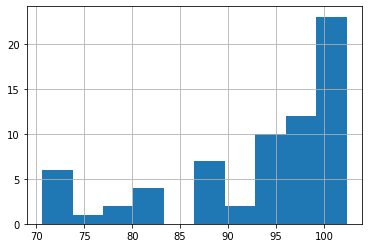

In [118]:
e_coli_wild_efflux[e_coli_wild_efflux['SMILES'].isin(evader_transforms.compound_structure_B)].INHIB_AVE_wild.hist()

In [ ]:
matches_for_evaders = []
for smile in range(len(efflux_evader)):
    matches_for_evaders.append(len(ecoli_wild_index[ecoli_wild_index['compound_structure_B'] == efflux_evader.SMILES.iloc[smile]]))

In [110]:
comp_a_evader_overlap.compound_structure_A.iloc[0]

'Cc1ccc2nc(-c3ccc(/N=C/c4cc(Br)cc(Cl)c4O)cc3)sc2c1'

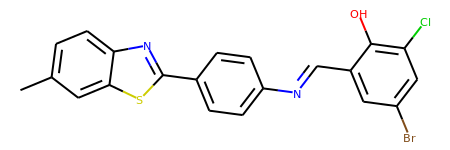

In [146]:
comp  = comp_a_evader_overlap.compound_structure_A.iloc[0]

Chem.MolFromSmiles(comp_a_evader_overlap[comp_a_evader_overlap['compound_structure_A'] == comp].iloc[0].compound_structure_A)

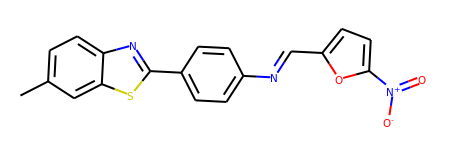

In [139]:
# evader: 

Chem.MolFromSmiles(comp_a_evader_overlap[comp_a_evader_overlap['compound_structure_A'] == comp].iloc[0].compound_structure_B)

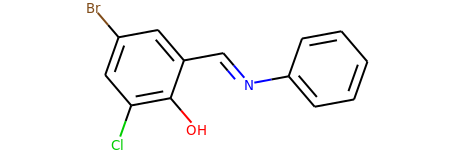

In [143]:
Chem.MolFromSmiles(comp_a_substrate_overlap[comp_a_substrate_overlap['compound_structure_A'] == comp].iloc[0].compound_structure_B)

In [115]:
comp_a_substrate_overlap

array(['O=C(CNc1ccc(Cl)cc1)N/N=C/c1ccc(Cl)cc1',
       'O=C(CSCc1ccc(Cl)cc1)N/N=C/c1ccc(Cl)cc1',
       'O=[N+]([O-])c1ccc(/N=C/c2cc(Cl)cc(Cl)c2O)cc1',
       'O=[N+]([O-])c1cc(Cl)cc(/C=N/c2ccc(F)cc2)c1O',
       'CCOc1ccc(/N=C/c2ccc([N+](=O)[O-])s2)cc1',
       'Cc1ccc(/N=C/c2ccc([N+](=O)[O-])s2)cc1I',
       'CC(=O)c1cccc(/N=C/c2ccc([N+](=O)[O-])s2)c1',
       'COc1cc(Br)cc(Br)c1OCC(=O)N/N=C/c1ccc([N+](=O)[O-])o1',
       'CC1(C)SC2C(NC(=O)Cc3ccccc3)C(=O)N2C1C(=O)[O-].[K+]',
       'O=C(CCl)NCCc1ccccc1', 'CC(Oc1ccccc1)C(=O)Nc1nc(-c2ccccn2)cs1',
       'COc1cc(C(=O)Nc2nccs2)cc(OC)c1OC',
       'C/C(=N/Nc1ccccc1[N+](=O)[O-])c1ccccc1',
       'CN(C)c1c([N+](=O)[O-])ncn1C', 'O=C(CSc1ccccn1)N/N=C/C=C/c1ccccc1',
       'CCn1cc(C(=O)O)c(=O)c2cnc(N3CCN(C(=S)Nc4cc(OC)ccc4OC)CC3)nc21',
       'Cc1cccc(O)c1/N=C/c1ccc([N+](=O)[O-])cc1',
       'O=[N+]([O-])c1ccc(/C=N/c2cc(Cl)ccc2O)cc1',
       'O=C(N/N=C/c1ccc([N+](=O)[O-])o1)c1cccc([N+](=O)[O-])c1',
       'Cc1n[n+]2c(C(=O)N3CCN(C)CC3)c(C)[n-]n

# Compound_A and LHS overlap in evader and substrate

In [5]:
l = [['DEV1', 'READ1'], ['DEV1', 'READ2'], ['DEV2','READ1']]
l = [tuple(i) for i in l]
df[df[['DEVICE', 'READING']].apply(tuple, axis = 1).isin(l)]

NameError: name 'df' is not defined

In [58]:
evader_transforms[['compound_structure_A', 'LHS', 'common_core']]

,compound_structure_A,LHS,common_core
5578,O/C(=C\C=N\c1ccc(Br)cc1)c1ccc(Br)cc1,[*:1]/C=N\c1ccc(Br)cc1,[*:1]/C=C(\O)c1ccc(Br)cc1
5581,Cc1ccc(/N=C/C=C(\O)c2ccc(Br)cc2)cc1,[*:1]/C=N\c1ccc(C)cc1,[*:1]/C=C(\O)c1ccc(Br)cc1
5583,O/C(=C\C=N\c1cccc(Cl)c1)c1ccc(Br)cc1,[*:1]/C=N\c1cccc(Cl)c1,[*:1]/C=C(\O)c1ccc(Br)cc1
13581,COc1ccc(/C=C2\C(=O)NC(=O)N(c3ccc(C)cc3)C2=O)cc1,[*:1]c1ccc(OC)cc1,[*:1]/C=C1\C(=O)NC(=O)N(c2ccc(C)cc2)C1=O
13602,COc1cc(/C=C2\C(=O)NC(=O)N(c3ccc(C)cc3)C2=O)cc(...,[*:1]c1cc(I)c(O)c(OC)c1,[*:1]/C=C1\C(=O)NC(=O)N(c2ccc(C)cc2)C1=O
...,...,...,...
1404516,CCCCn1ccc(=N)cc1.I,[*:1]CCCC,[*:1]n1ccc(=N)cc1
1404517,CCCCn1ccc(=N)cc1.I,[*:1]CCCC,[*:1]n1ccc(=N)cc1
1404520,Br.CCCCCCn1ccc(=N)cc1,[*:1]CCCCCC,[*:1]n1ccc(=N)cc1
1404521,Br.CCCCCCn1ccc(=N)cc1,[*:1]CCCCCC,[*:1]n1ccc(=N)cc1


In [57]:
evader_transforms[['compound_structure_A', 'LHS', 'common_core']].drop_duplicates()

,compound_structure_A,LHS,common_core
5578,O/C(=C\C=N\c1ccc(Br)cc1)c1ccc(Br)cc1,[*:1]/C=N\c1ccc(Br)cc1,[*:1]/C=C(\O)c1ccc(Br)cc1
5581,Cc1ccc(/N=C/C=C(\O)c2ccc(Br)cc2)cc1,[*:1]/C=N\c1ccc(C)cc1,[*:1]/C=C(\O)c1ccc(Br)cc1
5583,O/C(=C\C=N\c1cccc(Cl)c1)c1ccc(Br)cc1,[*:1]/C=N\c1cccc(Cl)c1,[*:1]/C=C(\O)c1ccc(Br)cc1
13581,COc1ccc(/C=C2\C(=O)NC(=O)N(c3ccc(C)cc3)C2=O)cc1,[*:1]c1ccc(OC)cc1,[*:1]/C=C1\C(=O)NC(=O)N(c2ccc(C)cc2)C1=O
13602,COc1cc(/C=C2\C(=O)NC(=O)N(c3ccc(C)cc3)C2=O)cc(...,[*:1]c1cc(I)c(O)c(OC)c1,[*:1]/C=C1\C(=O)NC(=O)N(c2ccc(C)cc2)C1=O
...,...,...,...
1404505,Br.CCn1ccc(=N)cc1,[*:1]CC,[*:1]n1ccc(=N)cc1
1404511,CCCn1ccc(=N)cc1.I,[*:1]CCC,[*:1]n1ccc(=N)cc1
1404516,CCCCn1ccc(=N)cc1.I,[*:1]CCCC,[*:1]n1ccc(=N)cc1
1404520,Br.CCCCCCn1ccc(=N)cc1,[*:1]CCCCCC,[*:1]n1ccc(=N)cc1


In [4]:
evader_tuples = evader_transforms[['compound_structure_A', 'LHS', 'common_core']].apply(tuple, axis = 1).drop_duplicates()

substrate_tuples = substrate_transforms[['compound_structure_A', 'LHS', 'common_core']].apply(tuple, axis = 1).drop_duplicates()

In [5]:
sub_overlap = substrate_transforms[substrate_transforms[['compound_structure_A', 'LHS', 'common_core']].apply(tuple, axis = 1).isin(evader_tuples)]

evade_overlap = evader_transforms[evader_transforms[['compound_structure_A', 'LHS', 'common_core']].apply(tuple, axis = 1).isin(substrate_tuples)]

In [154]:
substrate_transforms.merge(evader_transforms, on=['compound_structure_A', 'LHS', 'common_core'], suffixes=['_substrate','_evader'])

,compound_structure_A,compound_structure_B_substrate,idsmiles_A_substrate,idsmiles_B_substrate,smirks_substrate,common_core,measurement_A_substrate,measurement_B_substrate,measurement_delta_substrate,LHS,RHS_substrate,compound_structure_B_evader,idsmiles_A_evader,idsmiles_B_evader,smirks_evader,measurement_A_evader,measurement_B_evader,measurement_delta_evader,RHS_evader
0,C/C=C/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,O=C(N/N=C/c1cc([N+](=O)[O-])ccc1O)C(F)(F)C(F)(...,12181,12182,[*:1]/C=C\C>>[*:1]c1cc([N+](=O)[O-])ccc1O,[*:1]/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,20.09,63.12,43.03,[*:1]/C=C\C,[*:1]c1cc([N+](=O)[O-])ccc1O,COc1ccc(O)c(/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(...,12181,12199,[*:1]/C=C\C>>[*:1]c1cc(OC)ccc1O,20.09,45.24,25.15,[*:1]c1cc(OC)ccc1O
1,C/C=C/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,O=C(N/N=C/c1ccc(O)cc1)C(F)(F)C(F)(F)C(F)(F)C(F...,12181,12189,[*:1]/C=C\C>>[*:1]c1ccc(O)cc1,[*:1]/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,20.09,62.07,41.98,[*:1]/C=C\C,[*:1]c1ccc(O)cc1,COc1ccc(O)c(/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(...,12181,12199,[*:1]/C=C\C>>[*:1]c1cc(OC)ccc1O,20.09,45.24,25.15,[*:1]c1cc(OC)ccc1O
2,C/C=C/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,O=C(N/N=C/c1ccc(O)cc1O)C(F)(F)C(F)(F)C(F)(F)C(...,12181,12201,[*:1]/C=C\C>>[*:1]c1ccc(O)cc1O,[*:1]/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,20.09,49.35,29.26,[*:1]/C=C\C,[*:1]c1ccc(O)cc1O,COc1ccc(O)c(/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(...,12181,12199,[*:1]/C=C\C>>[*:1]c1cc(OC)ccc1O,20.09,45.24,25.15,[*:1]c1cc(OC)ccc1O
3,O=C(N/N=C/c1c(Cl)cccc1Cl)C(F)(F)C(F)(F)C(F)(F)...,O=C(N/N=C/c1cc([N+](=O)[O-])ccc1O)C(F)(F)C(F)(...,12198,12182,[*:1]c1c(Cl)cccc1Cl>>[*:1]c1cc([N+](=O)[O-])ccc1O,[*:1]/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,-1.12,63.12,64.24,[*:1]c1c(Cl)cccc1Cl,[*:1]c1cc([N+](=O)[O-])ccc1O,COc1ccc(O)c(/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(...,12198,12199,[*:1]c1c(Cl)cccc1Cl>>[*:1]c1cc(OC)ccc1O,-1.12,45.24,46.36,[*:1]c1cc(OC)ccc1O
4,O=C(N/N=C/c1c(Cl)cccc1Cl)C(F)(F)C(F)(F)C(F)(F)...,O=C(N/N=C/c1ccc(O)cc1)C(F)(F)C(F)(F)C(F)(F)C(F...,12198,12189,[*:1]c1c(Cl)cccc1Cl>>[*:1]c1ccc(O)cc1,[*:1]/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,-1.12,62.07,63.19,[*:1]c1c(Cl)cccc1Cl,[*:1]c1ccc(O)cc1,COc1ccc(O)c(/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(...,12198,12199,[*:1]c1c(Cl)cccc1Cl>>[*:1]c1cc(OC)ccc1O,-1.12,45.24,46.36,[*:1]c1cc(OC)ccc1O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,CCCn1ccc(=N)cc1.I,CCCCCCCn1ccc(=N)cc1.I,28118,28233,[*:1]CCC>>[*:1]CCCCCCC,[*:1]n1ccc(=N)cc1,1.42,56.99,55.57,[*:1]CCC,[*:1]CCCCCCC,Br.CCCCCCCCCCn1ccc(=N)cc1,28118,28236,[*:1]CCC>>[*:1]CCCCCCCCCC,1.42,-5.56,-6.98,[*:1]CCCCCCCCCC
197,CCCCn1ccc(=N)cc1.I,CCCCCCCn1ccc(=N)cc1.I,28145,28233,[*:1]CCCC>>[*:1]CCCCCCC,[*:1]n1ccc(=N)cc1,-14.52,56.99,71.51,[*:1]CCCC,[*:1]CCCCCCC,Br.CCCCCCCCn1ccc(=N)cc1,28145,28235,[*:1]CCCC>>[*:1]CCCCCCCC,-14.52,32.75,47.27,[*:1]CCCCCCCC
198,CCCCn1ccc(=N)cc1.I,CCCCCCCn1ccc(=N)cc1.I,28145,28233,[*:1]CCCC>>[*:1]CCCCCCC,[*:1]n1ccc(=N)cc1,-14.52,56.99,71.51,[*:1]CCCC,[*:1]CCCCCCC,Br.CCCCCCCCCCn1ccc(=N)cc1,28145,28236,[*:1]CCCC>>[*:1]CCCCCCCCCC,-14.52,-5.56,8.96,[*:1]CCCCCCCCCC
199,Br.CCCCCCn1ccc(=N)cc1,CCCCCCCn1ccc(=N)cc1.I,28228,28233,[*:1]CCCCCC>>[*:1]CCCCCCC,[*:1]n1ccc(=N)cc1,13.72,56.99,43.27,[*:1]CCCCCC,[*:1]CCCCCCC,Br.CCCCCCCCn1ccc(=N)cc1,28228,28235,[*:1]CCCCCC>>[*:1]CCCCCCCC,13.72,32.75,19.03,[*:1]CCCCCCCC


In [4]:
comp_a_lhs_overlap = evader_transforms.merge(substrate_transforms, on=['compound_structure_A', 'LHS', 'common_core'], suffixes=['_evader','_substrate'])

In [74]:
comp_a_lhs_overlap.to_pickle('data_curated/comp_a_lhs_overlap.pkl')

In [5]:
len(comp_a_lhs_overlap.compound_structure_A.unique())

85

In [77]:
len(comp_a_lhs_overlap)

201

In [79]:
len(comp_a_lhs_overlap.compound_structure_B_substrate.unique())

39

In [80]:
len(comp_a_lhs_overlap.compound_structure_B_evader.unique())

21

In [15]:
lhs_and_comp_a_evader = comp_a_evader_overlap[(comp_a_evader_overlap['LHS'].isin(comp_a_substrate_overlap['LHS'].values)) & (comp_a_evader_overlap['compound_structure_A'].isin(comp_a_substrate_overlap['compound_structure_A'].values))]

In [16]:
lhs_and_comp_a_substrate = comp_a_substrate_overlap[comp_a_substrate_overlap['LHS'].isin(comp_a_evader_overlap['LHS'].values) & (comp_a_substrate_overlap['compound_structure_A'].isin(comp_a_evader_overlap['compound_structure_A'].values))]

In [17]:
len(lhs_and_comp_a_evader), len(lhs_and_comp_a_substrate)

(120, 211)

In [21]:
len(lhs_and_comp_a_evader.LHS.unique())

98

# Plot some overlapping compounds 2.0

181 transfroms in substrates that equate to 85 compound_A into 39 compound B

111 transfroms in evader that equate to 85 compound_A into 21 compound B

In [68]:
len(sub_overlap.LHS.unique())

93

In [70]:
len(evade_overlap.LHS.unique())

93

In [6]:
len(sub_overlap), len(sub_overlap.compound_structure_A.unique()), len(sub_overlap.compound_structure_B.unique())

(181, 85, 39)

In [7]:
len(evade_overlap), len(evade_overlap.compound_structure_A.unique()), len(evade_overlap.compound_structure_B.unique())

(111, 85, 21)

In [72]:
evade_overlap.drop_duplicates()

,compound_structure_A,compound_structure_B,idsmiles_A,idsmiles_B,smirks,common_core,measurement_A,measurement_B,measurement_delta,LHS,RHS,core_mol,core_fps
24121,C/C=C/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,COc1ccc(O)c(/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(...,12181,12199,[*:1]/C=C\C>>[*:1]c1cc(OC)ccc1O,[*:1]/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,20.09,45.24,25.15,[*:1]/C=C\C,[*:1]c1cc(OC)ccc1O,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
24216,O=C(N/N=C/c1c(Cl)cccc1Cl)C(F)(F)C(F)(F)C(F)(F)...,COc1ccc(O)c(/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(...,12198,12199,[*:1]c1c(Cl)cccc1Cl>>[*:1]c1cc(OC)ccc1O,[*:1]/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,-1.12,45.24,46.36,[*:1]c1c(Cl)cccc1Cl,[*:1]c1cc(OC)ccc1O,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
24304,COc1cc(/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)...,COc1ccc(O)c(/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(...,12194,12199,[*:1]c1ccc([*:2])c(OC)c1>>[*:2]c1ccc(OC)cc1[*:1],[*:1]/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,23.46,45.24,21.78,[*:1]c1ccc([*:2])c(OC)c1,[*:2]c1ccc(OC)cc1[*:1],"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
58739,Cc1cccc(O)c1/N=C/c1cc(Br)cc(Br)c1O,Cc1cccc(O)c1/N=C/c1cc(I)cc(I)c1O,24071,24075,[*:1]c1cc(Br)cc(Br)c1O>>[*:1]c1cc(I)cc(I)c1O,[*:1]/C=N/c1c(C)cccc1O,11.55,38.39,26.84,[*:1]c1cc(Br)cc(Br)c1O,[*:1]c1cc(I)cc(I)c1O,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
58746,Cc1cccc(O)c1/N=C/c1cc(Br)cc(Cl)c1O,Cc1cccc(O)c1/N=C/c1cc(I)cc(I)c1O,24072,24075,[*:1]c1cc(Br)cc(Cl)c1O>>[*:1]c1cc(I)cc(I)c1O,[*:1]/C=N/c1c(C)cccc1O,6.35,38.39,32.04,[*:1]c1cc(Br)cc(Cl)c1O,[*:1]c1cc(I)cc(I)c1O,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404512,CCCn1ccc(=N)cc1.I,Br.CCCCCCCCCCn1ccc(=N)cc1,28118,28236,[*:1]CCC>>[*:1]CCCCCCCCCC,[*:1]n1ccc(=N)cc1,1.42,-5.56,-6.98,[*:1]CCC,[*:1]CCCCCCCCCC,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1404516,CCCCn1ccc(=N)cc1.I,Br.CCCCCCCCn1ccc(=N)cc1,28145,28235,[*:1]CCCC>>[*:1]CCCCCCCC,[*:1]n1ccc(=N)cc1,-14.52,32.75,47.27,[*:1]CCCC,[*:1]CCCCCCCC,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1404517,CCCCn1ccc(=N)cc1.I,Br.CCCCCCCCCCn1ccc(=N)cc1,28145,28236,[*:1]CCCC>>[*:1]CCCCCCCCCC,[*:1]n1ccc(=N)cc1,-14.52,-5.56,8.96,[*:1]CCCC,[*:1]CCCCCCCCCC,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1404520,Br.CCCCCCn1ccc(=N)cc1,Br.CCCCCCCCn1ccc(=N)cc1,28228,28235,[*:1]CCCCCC>>[*:1]CCCCCCCC,[*:1]n1ccc(=N)cc1,13.72,32.75,19.03,[*:1]CCCCCC,[*:1]CCCCCCCC,"<img data-content=""rdkit/molecule"" src=""data:i...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [80]:
for i in range(0):
    comp_a = Chem.MolFromSmiles(evade_overlap.compound_structure_A.unique().iloc[nr])
    
    comp_b_evader = Chem.MolFromSmiles(evade_overlap.compound_structure_B.iloc[nr])


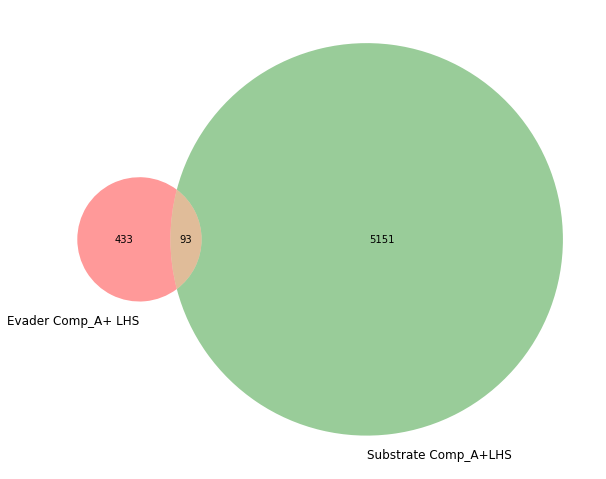

In [52]:
plt.figure(figsize=(10,10))


venn2([ set(evader_transforms[['compound_structure_A', 'LHS']].apply(tuple, axis = 1)), 
        set(substrate_transforms[['compound_structure_A', 'LHS']].apply(tuple, axis = 1))],
        set_labels=('Evader Comp_A+ LHS', 'Substrate Comp_A+LHS')
     )

In [58]:
mol = evade_overlap.core_mol.iloc[0]

In [43]:
a = evade_overlap['core_fps'].iloc[0]

# Plot some overlapping compounds

In [148]:
comp_a_lhs_overlap[comp_a_lhs_overlap.compound_structure_B_evader.isin(comp_a_lhs_overlap.compound_structure_B_evader.unique())]

,compound_structure_A,compound_structure_B_evader,idsmiles_A_evader,idsmiles_B_evader,smirks_evader,common_core,measurement_A_evader,measurement_B_evader,measurement_delta_evader,LHS,RHS_evader,compound_structure_B_substrate,idsmiles_A_substrate,idsmiles_B_substrate,smirks_substrate,measurement_A_substrate,measurement_B_substrate,measurement_delta_substrate,RHS_substrate
0,C/C=C/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,COc1ccc(O)c(/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(...,12181,12199,[*:1]/C=C\C>>[*:1]c1cc(OC)ccc1O,[*:1]/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,20.09,45.24,25.15,[*:1]/C=C\C,[*:1]c1cc(OC)ccc1O,O=C(N/N=C/c1cc([N+](=O)[O-])ccc1O)C(F)(F)C(F)(...,12181,12182,[*:1]/C=C\C>>[*:1]c1cc([N+](=O)[O-])ccc1O,20.09,63.12,43.03,[*:1]c1cc([N+](=O)[O-])ccc1O
1,C/C=C/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,COc1ccc(O)c(/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(...,12181,12199,[*:1]/C=C\C>>[*:1]c1cc(OC)ccc1O,[*:1]/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,20.09,45.24,25.15,[*:1]/C=C\C,[*:1]c1cc(OC)ccc1O,O=C(N/N=C/c1ccc(O)cc1)C(F)(F)C(F)(F)C(F)(F)C(F...,12181,12189,[*:1]/C=C\C>>[*:1]c1ccc(O)cc1,20.09,62.07,41.98,[*:1]c1ccc(O)cc1
2,C/C=C/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,COc1ccc(O)c(/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(...,12181,12199,[*:1]/C=C\C>>[*:1]c1cc(OC)ccc1O,[*:1]/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,20.09,45.24,25.15,[*:1]/C=C\C,[*:1]c1cc(OC)ccc1O,O=C(N/N=C/c1ccc(O)cc1O)C(F)(F)C(F)(F)C(F)(F)C(...,12181,12201,[*:1]/C=C\C>>[*:1]c1ccc(O)cc1O,20.09,49.35,29.26,[*:1]c1ccc(O)cc1O
3,O=C(N/N=C/c1c(Cl)cccc1Cl)C(F)(F)C(F)(F)C(F)(F)...,COc1ccc(O)c(/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(...,12198,12199,[*:1]c1c(Cl)cccc1Cl>>[*:1]c1cc(OC)ccc1O,[*:1]/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,-1.12,45.24,46.36,[*:1]c1c(Cl)cccc1Cl,[*:1]c1cc(OC)ccc1O,O=C(N/N=C/c1cc([N+](=O)[O-])ccc1O)C(F)(F)C(F)(...,12198,12182,[*:1]c1c(Cl)cccc1Cl>>[*:1]c1cc([N+](=O)[O-])ccc1O,-1.12,63.12,64.24,[*:1]c1cc([N+](=O)[O-])ccc1O
4,O=C(N/N=C/c1c(Cl)cccc1Cl)C(F)(F)C(F)(F)C(F)(F)...,COc1ccc(O)c(/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(...,12198,12199,[*:1]c1c(Cl)cccc1Cl>>[*:1]c1cc(OC)ccc1O,[*:1]/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,-1.12,45.24,46.36,[*:1]c1c(Cl)cccc1Cl,[*:1]c1cc(OC)ccc1O,O=C(N/N=C/c1ccc(O)cc1)C(F)(F)C(F)(F)C(F)(F)C(F...,12198,12189,[*:1]c1c(Cl)cccc1Cl>>[*:1]c1ccc(O)cc1,-1.12,62.07,63.19,[*:1]c1ccc(O)cc1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,CCCn1ccc(=N)cc1.I,Br.CCCCCCCCCCn1ccc(=N)cc1,28118,28236,[*:1]CCC>>[*:1]CCCCCCCCCC,[*:1]n1ccc(=N)cc1,1.42,-5.56,-6.98,[*:1]CCC,[*:1]CCCCCCCCCC,CCCCCCCn1ccc(=N)cc1.I,28118,28233,[*:1]CCC>>[*:1]CCCCCCC,1.42,56.99,55.57,[*:1]CCCCCCC
197,CCCCn1ccc(=N)cc1.I,Br.CCCCCCCCn1ccc(=N)cc1,28145,28235,[*:1]CCCC>>[*:1]CCCCCCCC,[*:1]n1ccc(=N)cc1,-14.52,32.75,47.27,[*:1]CCCC,[*:1]CCCCCCCC,CCCCCCCn1ccc(=N)cc1.I,28145,28233,[*:1]CCCC>>[*:1]CCCCCCC,-14.52,56.99,71.51,[*:1]CCCCCCC
198,CCCCn1ccc(=N)cc1.I,Br.CCCCCCCCCCn1ccc(=N)cc1,28145,28236,[*:1]CCCC>>[*:1]CCCCCCCCCC,[*:1]n1ccc(=N)cc1,-14.52,-5.56,8.96,[*:1]CCCC,[*:1]CCCCCCCCCC,CCCCCCCn1ccc(=N)cc1.I,28145,28233,[*:1]CCCC>>[*:1]CCCCCCC,-14.52,56.99,71.51,[*:1]CCCCCCC
199,Br.CCCCCCn1ccc(=N)cc1,Br.CCCCCCCCn1ccc(=N)cc1,28228,28235,[*:1]CCCCCC>>[*:1]CCCCCCCC,[*:1]n1ccc(=N)cc1,13.72,32.75,19.03,[*:1]CCCCCC,[*:1]CCCCCCCC,CCCCCCCn1ccc(=N)cc1.I,28228,28233,[*:1]CCCCCC>>[*:1]CCCCCCC,13.72,56.99,43.27,[*:1]CCCCCCC


In [4]:
len(comp_a_lhs_overlap.compound_structure_B_substrate.unique())

39

In [146]:
len(comp_a_lhs_overlap.compound_structure_A.unique())

85

In [97]:
comp_a_lhs_overlap

,compound_structure_A,compound_structure_B_evader,idsmiles_A_evader,idsmiles_B_evader,smirks_evader,common_core,measurement_A_evader,measurement_B_evader,measurement_delta_evader,LHS,RHS_evader,compound_structure_B_substrate,idsmiles_A_substrate,idsmiles_B_substrate,smirks_substrate,measurement_A_substrate,measurement_B_substrate,measurement_delta_substrate,RHS_substrate
0,C/C=C/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,COc1ccc(O)c(/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(...,12181,12199,[*:1]/C=C\C>>[*:1]c1cc(OC)ccc1O,[*:1]/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,20.09,45.24,25.15,[*:1]/C=C\C,[*:1]c1cc(OC)ccc1O,O=C(N/N=C/c1cc([N+](=O)[O-])ccc1O)C(F)(F)C(F)(...,12181,12182,[*:1]/C=C\C>>[*:1]c1cc([N+](=O)[O-])ccc1O,20.09,63.12,43.03,[*:1]c1cc([N+](=O)[O-])ccc1O
1,C/C=C/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,COc1ccc(O)c(/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(...,12181,12199,[*:1]/C=C\C>>[*:1]c1cc(OC)ccc1O,[*:1]/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,20.09,45.24,25.15,[*:1]/C=C\C,[*:1]c1cc(OC)ccc1O,O=C(N/N=C/c1ccc(O)cc1)C(F)(F)C(F)(F)C(F)(F)C(F...,12181,12189,[*:1]/C=C\C>>[*:1]c1ccc(O)cc1,20.09,62.07,41.98,[*:1]c1ccc(O)cc1
2,C/C=C/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,COc1ccc(O)c(/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(...,12181,12199,[*:1]/C=C\C>>[*:1]c1cc(OC)ccc1O,[*:1]/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,20.09,45.24,25.15,[*:1]/C=C\C,[*:1]c1cc(OC)ccc1O,O=C(N/N=C/c1ccc(O)cc1O)C(F)(F)C(F)(F)C(F)(F)C(...,12181,12201,[*:1]/C=C\C>>[*:1]c1ccc(O)cc1O,20.09,49.35,29.26,[*:1]c1ccc(O)cc1O
3,O=C(N/N=C/c1c(Cl)cccc1Cl)C(F)(F)C(F)(F)C(F)(F)...,COc1ccc(O)c(/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(...,12198,12199,[*:1]c1c(Cl)cccc1Cl>>[*:1]c1cc(OC)ccc1O,[*:1]/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,-1.12,45.24,46.36,[*:1]c1c(Cl)cccc1Cl,[*:1]c1cc(OC)ccc1O,O=C(N/N=C/c1cc([N+](=O)[O-])ccc1O)C(F)(F)C(F)(...,12198,12182,[*:1]c1c(Cl)cccc1Cl>>[*:1]c1cc([N+](=O)[O-])ccc1O,-1.12,63.12,64.24,[*:1]c1cc([N+](=O)[O-])ccc1O
4,O=C(N/N=C/c1c(Cl)cccc1Cl)C(F)(F)C(F)(F)C(F)(F)...,COc1ccc(O)c(/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(...,12198,12199,[*:1]c1c(Cl)cccc1Cl>>[*:1]c1cc(OC)ccc1O,[*:1]/C=N/NC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,-1.12,45.24,46.36,[*:1]c1c(Cl)cccc1Cl,[*:1]c1cc(OC)ccc1O,O=C(N/N=C/c1ccc(O)cc1)C(F)(F)C(F)(F)C(F)(F)C(F...,12198,12189,[*:1]c1c(Cl)cccc1Cl>>[*:1]c1ccc(O)cc1,-1.12,62.07,63.19,[*:1]c1ccc(O)cc1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,CCCn1ccc(=N)cc1.I,Br.CCCCCCCCCCn1ccc(=N)cc1,28118,28236,[*:1]CCC>>[*:1]CCCCCCCCCC,[*:1]n1ccc(=N)cc1,1.42,-5.56,-6.98,[*:1]CCC,[*:1]CCCCCCCCCC,CCCCCCCn1ccc(=N)cc1.I,28118,28233,[*:1]CCC>>[*:1]CCCCCCC,1.42,56.99,55.57,[*:1]CCCCCCC
197,CCCCn1ccc(=N)cc1.I,Br.CCCCCCCCn1ccc(=N)cc1,28145,28235,[*:1]CCCC>>[*:1]CCCCCCCC,[*:1]n1ccc(=N)cc1,-14.52,32.75,47.27,[*:1]CCCC,[*:1]CCCCCCCC,CCCCCCCn1ccc(=N)cc1.I,28145,28233,[*:1]CCCC>>[*:1]CCCCCCC,-14.52,56.99,71.51,[*:1]CCCCCCC
198,CCCCn1ccc(=N)cc1.I,Br.CCCCCCCCCCn1ccc(=N)cc1,28145,28236,[*:1]CCCC>>[*:1]CCCCCCCCCC,[*:1]n1ccc(=N)cc1,-14.52,-5.56,8.96,[*:1]CCCC,[*:1]CCCCCCCCCC,CCCCCCCn1ccc(=N)cc1.I,28145,28233,[*:1]CCCC>>[*:1]CCCCCCC,-14.52,56.99,71.51,[*:1]CCCCCCC
199,Br.CCCCCCn1ccc(=N)cc1,Br.CCCCCCCCn1ccc(=N)cc1,28228,28235,[*:1]CCCCCC>>[*:1]CCCCCCCC,[*:1]n1ccc(=N)cc1,13.72,32.75,19.03,[*:1]CCCCCC,[*:1]CCCCCCCC,CCCCCCCn1ccc(=N)cc1.I,28228,28233,[*:1]CCCCCC>>[*:1]CCCCCCC,13.72,56.99,43.27,[*:1]CCCCCCC


In [108]:
def draw_full_mols(nr, name, save):

    # compound_A
    comp_a = Chem.MolFromSmiles(comp_a_lhs_overlap.compound_structure_A.iloc[nr])

    core = Chem.MolFromSmiles(comp_a_lhs_overlap.compound_structure_A.iloc[nr])

    # compound_B_evader
    comp_b_evader = Chem.MolFromSmiles(comp_a_lhs_overlap.compound_structure_B_evader.iloc[nr])

    # compound_B_substrate
    comp_b_substrate = Chem.MolFromSmiles(comp_a_lhs_overlap.compound_structure_B_substrate.iloc[nr])

    # labels
    inactive_label = e_coli_wild_efflux[e_coli_wild_efflux['SMILES'] == comp_a_lhs_overlap.compound_structure_A.iloc[nr]][['INHIB_AVE_wild', 'INHIB_AVE_efflux']].values

    evader_label = e_coli_wild_efflux[e_coli_wild_efflux['SMILES'] == comp_a_lhs_overlap.compound_structure_B_evader.iloc[nr]][['INHIB_AVE_wild', 'INHIB_AVE_efflux']].values

    substrate_label = e_coli_wild_efflux[e_coli_wild_efflux['SMILES'] == comp_a_lhs_overlap.compound_structure_B_substrate.iloc[nr]][['INHIB_AVE_wild', 'INHIB_AVE_efflux']].values

    lab = ['Inactive no_{}; '+ '\n' + 'WT: {}; tolC: {}'.format(nr, inactive_label[0][0], inactive_label[0][1]), 'Substrate no_{}; WT: {}; tolC: {}'.format(nr, substrate_label[0][0], substrate_label[0][1]), 'Evader no_{}; WT: {}; tolC: {}'.format(nr, evader_label[0][0], evader_label[0][1]),]

    mols=[comp_a, comp_b_substrate, comp_b_evader]
    font = {'fontsize': 10}

    img = Chem.Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(400,400), legends=lab, useSVG=True), 
    
    if save==True:

        with open(name + '.svg', 'w') as f:
            f.write(img[0].data)

        return print('saved {}.svg'.format(name))
    else:
        
        return img[0]

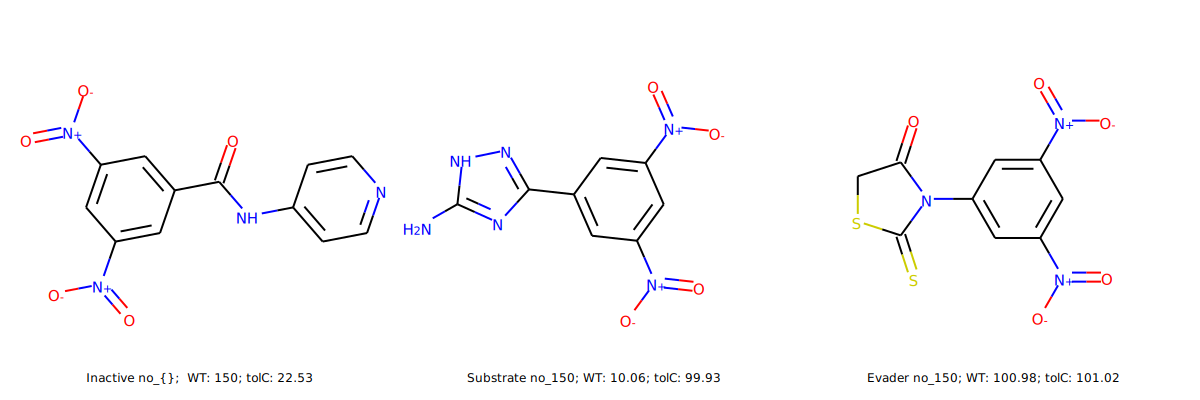

In [109]:
draw_full_mols(150, 'figure_mols/compound_80_full', save = False)


In [49]:
def draw_partial_mols(nr, name, save):

    # compound_A
    core = Chem.MolFromSmiles(comp_a_lhs_overlap.common_core.iloc[nr])

    # LHS
    lhs = Chem.MolFromSmiles(comp_a_lhs_overlap.LHS.iloc[nr])

    # compound_B_evader
    RHS_evader = Chem.MolFromSmiles(comp_a_lhs_overlap.RHS_evader.iloc[nr])

    # compound_B_substrate
    RHS_substrate = Chem.MolFromSmiles(comp_a_lhs_overlap.RHS_substrate.iloc[nr])

    mols=[core, lhs , RHS_substrate, RHS_evader]
    
    # labels
    inactive_label = e_coli_wild_efflux[e_coli_wild_efflux['SMILES'] == comp_a_lhs_overlap.compound_structure_A.iloc[nr]][['INHIB_AVE_wild', 'INHIB_AVE_efflux']].values

    evader_label = e_coli_wild_efflux[e_coli_wild_efflux['SMILES'] == comp_a_lhs_overlap.compound_structure_B_evader.iloc[nr]][['INHIB_AVE_wild', 'INHIB_AVE_efflux']].values

    substrate_label = e_coli_wild_efflux[e_coli_wild_efflux['SMILES'] == comp_a_lhs_overlap.compound_structure_B_substrate.iloc[nr]][['INHIB_AVE_wild', 'INHIB_AVE_efflux']].values

    lab = ['Common core no_{}'.format(nr), 'Inactive; WT: {:.1f}%; tolC: {:.1f}%'.format(inactive_label[0][0], inactive_label[0][1]), 'Substrate; WT: {:.1f}%; tolC: {:.1f}%'.format(substrate_label[0][0], substrate_label[0][1]), 'Evader; WT: {:.1f}%; tolC: {:.1f}%'.format(evader_label[0][0], evader_label[0][1]),]

    img = Chem.Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(250,250), legends=lab, useSVG=True)
    
    if save == True:
        with open(name + '.svg', 'w') as f:
            f.write(img.data)

        return print('saved {}.svg'.format(name))
    else:
        return Chem.Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(250,250), legends=lab, useSVG=True)


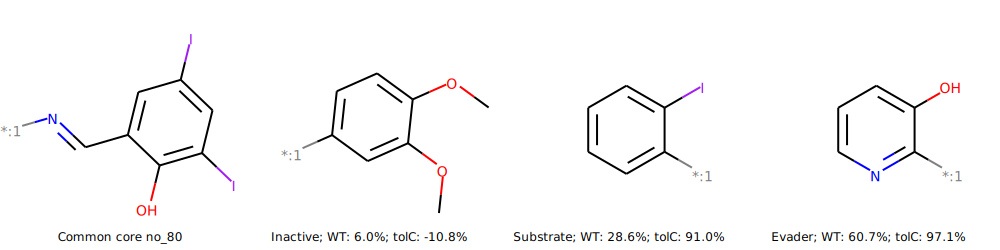

In [61]:
# nr = 80
draw_partial_mols(80, 'figure_mols/compound_80_partial', save=False)


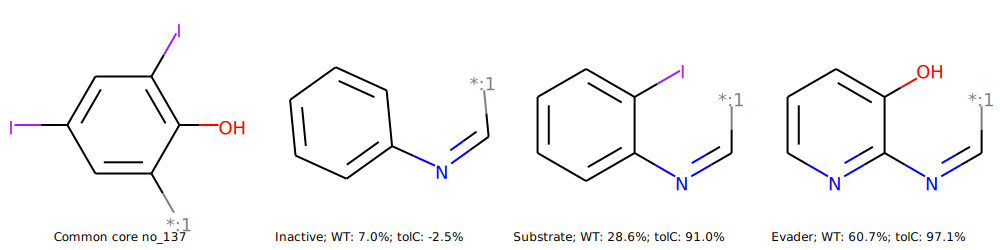

In [76]:
no=137

draw_partial_mols(no, 'figure_mols/compound_'+str(no)+'_partial', save=False)


In [64]:
nr=137
core = comp_a_lhs_overlap.common_core.iloc[nr]
print('core:', core)
# LHS
lhs = comp_a_lhs_overlap.LHS.iloc[nr]
print('inactive:',lhs)
# compound_B_substrate
RHS_substrate = comp_a_lhs_overlap.RHS_substrate.iloc[nr]
print('RHS_substrate:',RHS_substrate)
# compound_B_evader
RHS_evader = comp_a_lhs_overlap.RHS_evader.iloc[nr]
print('RHS_evader:',RHS_evader)



core: [*:1]c1cc(I)cc(I)c1O
inactive: [*:1]/C=N\c1ccccc1
RHS_substrate: [*:1]/C=N\c1ccccc1I
RHS_evader: [*:1]/C=N\c1ncccc1O


In [53]:
import sympy.printing as printing
delta__y_l = sp.symbols('Delta__y_l')
print(printing.latex(delta__y_l))

\Delta^{y}_{l}


In [75]:
nr=137


# labels

inactive_label = e_coli_wild_efflux[e_coli_wild_efflux['SMILES'] == comp_a_lhs_overlap.compound_structure_A.iloc[nr]][['INHIB_AVE_wild', 'INHIB_AVE_efflux']].values

evader_label = e_coli_wild_efflux[e_coli_wild_efflux['SMILES'] == comp_a_lhs_overlap.compound_structure_B_evader.iloc[nr]][['INHIB_AVE_wild', 'INHIB_AVE_efflux']].values

substrate_label = e_coli_wild_efflux[e_coli_wild_efflux['SMILES'] == comp_a_lhs_overlap.compound_structure_B_substrate.iloc[nr]][['INHIB_AVE_wild', 'INHIB_AVE_efflux']].values

lab = ['Inactive; WT: {:.1f}%; tolC: {:.1f}%'.format(inactive_label[0][0], inactive_label[0][1]), 'Substrate; WT: {:.1f}%; tolC: {:.1f}%'.format(substrate_label[0][0], substrate_label[0][1]), 'Evader; WT: {:.1f}%; tolC: {:.1f}%'.format(evader_label[0][0], evader_label[0][1]),]

print(lab)



['Inactive; WT: 7.0%; tolC: -2.5%', 'Substrate; WT: 28.6%; tolC: 91.0%', 'Evader; WT: 60.7%; tolC: 97.1%']


In [94]:
mols=[]

labels=[]


for i in range(len(comp_a_lhs_overlap)):

    # compound_A
    core = Chem.MolFromSmiles(comp_a_lhs_overlap.common_core.iloc[i])
    # LHS
    lhs = Chem.MolFromSmiles(comp_a_lhs_overlap.LHS.iloc[i])
    # compound_B_evader
    RHS_evader = Chem.MolFromSmiles(comp_a_lhs_overlap.RHS_evader.iloc[i])
    # compound_B_substrate
    RHS_substrate = Chem.MolFromSmiles(comp_a_lhs_overlap.RHS_substrate.iloc[i])

#     mols=[core, lhs , RHS_substrate, RHS_evader]

    # labels
    inactive_label = e_coli_wild_efflux[e_coli_wild_efflux['SMILES'] == comp_a_lhs_overlap.compound_structure_A.iloc[i]][['INHIB_AVE_wild', 'INHIB_AVE_efflux']].values

    evader_label = e_coli_wild_efflux[e_coli_wild_efflux['SMILES'] == comp_a_lhs_overlap.compound_structure_B_evader.iloc[i]][['INHIB_AVE_wild', 'INHIB_AVE_efflux']].values

    substrate_label = e_coli_wild_efflux[e_coli_wild_efflux['SMILES'] == comp_a_lhs_overlap.compound_structure_B_substrate.iloc[i]][['INHIB_AVE_wild', 'INHIB_AVE_efflux']].values

    lab = ['Common core no_{}'.format(i), 'Inactive; WT: {:.1f}%; tolC: {:.1f}%'.format(inactive_label[0][0], inactive_label[0][1]), 'Substrate; WT: {:.1f}%; tolC: {:.1f}%'.format(substrate_label[0][0], substrate_label[0][1]), 'Evader; WT: {:.1f}%; tolC: {:.1f}%'.format(evader_label[0][0], evader_label[0][1]),]

# img = Chem.Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(250,250), legends=lab, useSVG=True)
    mols.append(core)
    mols.append(lhs)
    mols.append(RHS_substrate)
    mols.append(RHS_evader)
    
    labels.append(lab[0])
    labels.append(lab[1])
    labels.append(lab[2])
    labels.append(lab[3])


img = Chem.Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(200,200), legends=labels, useSVG=False, maxMols= 600)

# with open('master_transform' + '.svg', 'w') as f:
#     f.write(img.data)

# print('saved {}.svg'.format(name))

In [95]:
img.save('master_transform.png')

# TSNE of overlap

In [87]:
evader_overlap = efflux_evader[efflux_evader['SMILES'].isin(comp_a_lhs_overlap.compound_structure_B_evader)]

In [80]:
inactive_overlap = inactive[inactive['SMILES'].isin(comp_a_lhs_overlap.compound_structure_A)]

In [82]:
substrate_overlap = efflux_substrate[efflux_substrate['SMILES'].isin(comp_a_lhs_overlap.compound_structure_B_substrate)]

In [89]:
one = evader_overlap.append(inactive_overlap)

In [97]:
two = one.append(substrate_overlap).reset_index(drop=True)

In [98]:
two_tsne =  master_functions.tsne_no_plot(two['fps'], 20)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 145 samples in 0.001s...
[t-SNE] Computed neighbors for 145 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 145 / 145
[t-SNE] Mean sigma: 0.928431
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.186184
[t-SNE] KL divergence after 800 iterations: 0.193251


In [99]:
two.Class.value_counts()

Inactive            85
Efflux Substrate    39
Efflux Evader       21
Name: Class, dtype: int64

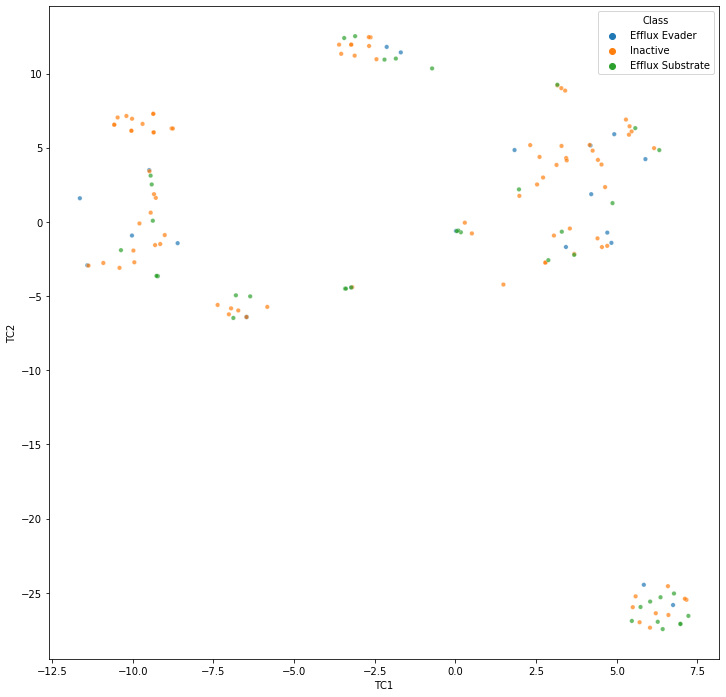

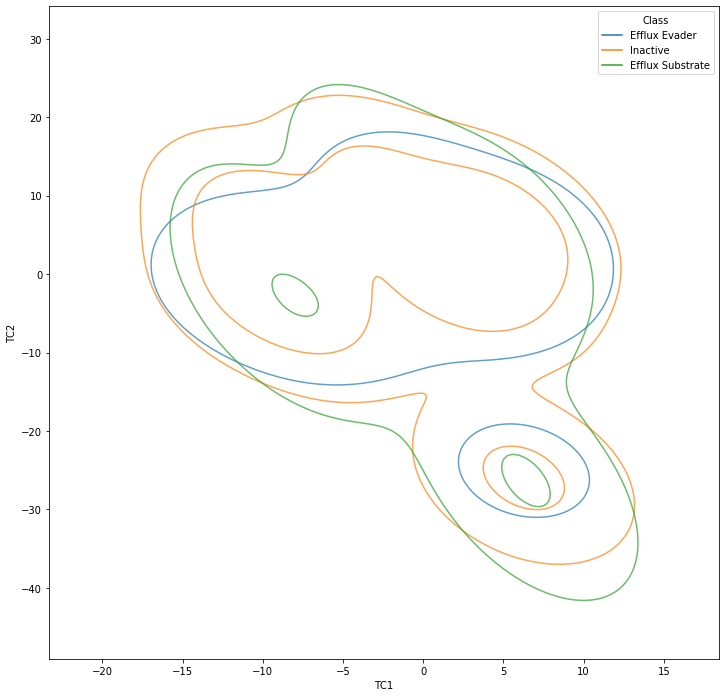

In [100]:
fig, ax = plt.subplots(figsize=(12,12))

sns.scatterplot(x='TC1',y='TC2',data=two_tsne, s=20 ,alpha=0.7, hue=two['Class']) 

fig, ax = plt.subplots(figsize=(12,12))

sns.kdeplot(x='TC1',y='TC2',data=two_tsne,alpha=0.7, hue=two['Class'], levels = 3)